# Prelude
Hehe I really liked this activity. But I did the logistic regression a bit late and I am really out of energy now. So really sorry for doing only the required parts :c.

# Acknowledgements
I'd like to thank my instructors, Sir Rene Principe Jr. and Sir Kenneth Leo, for guiding me throughout the activity. I would also like to thank my professor, Ma'am Jing, for guiding me in my coding while my classmates and I worked in R202. I would also like to acknowledge my classmates: Abdel, Johnenn, Jonabel, Richmond, Lovely, Hans, Genesis, Jeruine, Rusher, and Ron for helping me complete this activity.

# Code starts Here

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import statistics as st
from PIL import Image
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
import os
from scipy.ndimage import binary_fill_holes
from sklearn.model_selection import train_test_split

image_repository = "./Image repository/"
data_repository = "./Features extracted/"

# initializing this so I have a placeholder
image = 0
R,G,B, ave_R,ave_G, ave_B = None, None, None, None, None, None
def g(a):
    pass

# Feature Extraction
For this part, I will first extract features from the fruits. The fruits that I will be using are bananas and apples from the Fruits 360 and Fruit Classsification data sets in kaggle. I'll extract the fruit's area, eccentricity, and average RGB values. 

I'll use the area parameter to determine if its just a rogue pixel during pre-processing. For the banana, all regions that are made up of less than $1000~\rm{pixels}$  will be removed. For the apple, $2000~\rm{pixels}$ is the threshold.

## Functions used

> #### ${\tt thresholding(image, stdev\_mult):}$
> 1. Accepts a grayscale image
> 2. Gets the median and standard deviation of the image.
> 3. Binarizes the image by zeroing out the values that are in the range [median - ${\tt stdev\_mult}\times$(stdev), median + ${\tt stdev\_mult}\times$(stdev)] and setting the other values to $1$.
> 4. Returns the binarized image.<br>
> $~$

In [2]:
def thresholding(image, stdev_mult):

    # I'll automate the thresholding. Since we know that the highest peak in the histogram represents the image's background, 
    # my left and right borders will be np.median(image) -+ stdev_mult*stdev respectively.
    peak_ = np.median(image.flatten())
    stdev_ = np.std(image.flatten())

    # Now setting up the borders
    left_border = int(np.floor(peak_ - stdev_mult*stdev_))
    right_border = int(np.ceil(peak_ + stdev_mult*stdev_))

    # Converting to binary through. The values to the left of the left border and to the right of the right boarder are set to 1.
    T, thresholded = cv2.threshold(image, left_border, right_border, cv2.THRESH_BINARY_INV)

    return thresholded


> #### ${\tt convert\_NCC(image):}$
> Converts an image into its normalized chromaticity coordinates and returns the converted image.<br>
> $~$

In [3]:
def convert_NCC(image):

    image_rgb = np.zeros(image.shape)

    image_R = image[...,0]
    image_G = image[...,1]
    image_B = image[...,2]

    image_R = (image_R - np.min(image_R))/(np.max(image_R) - np.min(image_R))
    image_G = (image_G - np.min(image_G))/(np.max(image_G) - np.min(image_G))
    image_B = (image_B - np.min(image_B))/(np.max(image_B) - np.min(image_B))

    # Adding 1e-8 so there's no 1/0
    I = image_R + image_G + image_B + 1e-8

    image_r = image_R/I
    image_g = image_G/I
    image_b = image_B/I

    image_rgb[...,0] = image_r
    image_rgb[...,1] = image_g
    image_rgb[...,2] = image_b

    image_rgb = cv2.normalize(image_rgb , None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return image_rgb

> #### ${\tt morphing\_time(filename, filetype, commands, record = False, ROI\_size = None,}$ 
> #### ${\tt blob\_numbers = False, bounding\_box = False):}$
> 1. opens the image with the stated ${\tt filename}$.
> 2. Loops through a list of ${\tt commands}$ which contains the morphological operations along with their parameters.
> 3. Displays the original image and the final processed image.
> 4. If ${\tt record}$ is ${\tt True}$, then the area, centroid, bounding box, perimeter, eccentricity, minor axis, and major axis of the detected objects are saved to a csv file
> 5. If ${\tt ROI\_size}$ is ${\tt True}$, then the measurements are converted to $\rm{cm}$ or whatever unit you want to set.
> 6. If ${\tt blob\_numbers}$ is ${\tt True}$, then a number is also displayed on the labelled objects.
> 6. If ${\tt bounding\_box}$ is ${\tt True}$, then the detected objects in the original image is enclosed in a box.
> $~$

In [4]:
def morphing_time(filename, commands, plotting = False):
    # Setting initial parameters
    cmap_color = "gray"
    image = cv2.imread(image_repository + filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()
    original_image_2 = image.copy()

    # This is where the commands are looped through
    for i in range(len(commands)):
        process = commands[i][0].lower()

        match process:
            
            case 'grayscale':       
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            case 'thresholding':
                image = thresholding(image, commands[i][1])
            case 'dilation':
                image = cv2.dilate(image, commands[i][1], iterations = commands[i][2])
            case 'erosion':
                image = cv2.erode(image, commands[i][1], commands[i][2])
            case 'opening':
                image = cv2.morphologyEx(image, cv2.MORPH_OPEN, commands[i][1])
            case 'closing':
                image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, commands[i][1])
            case 'median_blur':
                image = cv2.medianBlur(image, commands[i][1])
            case 'simple_binarize':
                # All pixels beow the boundary ares set to 0 and above are set to 1.
                boundary = np.percentile(image, commands[i][1])
                image[image <= boundary] = 0
                image[image > boundary] = 1  
            case 'invert':
                image= cv2.bitwise_not(image)
            case 'apply_mask':
                mask_2D = image.copy()
                mask = np.dstack([image,image,image])
                image = original_image*mask
            case 'separate_rgb':
                R,G,B = cv2.split(image)
            case 'average_rgb':
                ave_R = np.average(R[mask_2D == 1])
                ave_G = np.average(G[mask_2D == 1])
                ave_B = np.average(B[mask_2D == 1])
            case 'get_mask':
                image = mask_2D
            case 'save':
                labelled_image = label(image)
                regions = regionprops(labelled_image)
                props = regionprops_table(labelled_image, properties=commands[i][1])
                data = pd.DataFrame(props)
                data.drop(data[data['area'] <commands[i][2]].index, inplace=True)
            case 'fill_holes':
                image = binary_fill_holes(image)
            case 'convert_ncc':
                original_image = convert_NCC(image)
            case 'undo_ncc':
                original_image = original_image_2
            case 'done':
                break
                
            case other:
                print(commands[i][0] + " did nothing lol.")


    # For graphing
    if plotting == True:
        fig, ax = plt.subplots(1,2, figsize = (12,8))
        ax[0].imshow(original_image)
        ax[0].set_title(filename)

        ax[1].imshow(image, cmap = cmap_color)
        ax[1].set_title("Processed Image")

        plt.tight_layout()
        plt.show()
    return data, ave_R, ave_G, ave_B


## Outputs

### Preprocessing and feature extraction from the bananas

In [5]:
overall_data = pd.DataFrame(columns = ['area', 'eccentricity', 'ave_r', 'ave_g', 'ave_b'])
commands = [
            ['convert_ncc'],
            ['invert'],
            ['median_blur', 13],
            ['grayscale'],
            ['simple_binarize', 57.5],
            ['fill_holes'],
            ['apply_mask'],
            ['separate_RGB'],
            ['average_rgb'],
            ['get_mask'],
            ['save', ('area','centroid', 'bbox', 
                      'perimeter', 'eccentricity' , 
                      'orientation','axis_major_length',
                        'axis_minor_length'), 1000 ]
        ]
for images in os.listdir(image_repository + 'Banana/'):
 
    # check if the image ends with png
    if (images.endswith(".jpg")):
      data, ave_R, ave_G, ave_B = morphing_time('Banana/'+images, commands)
      new_data = [data.iloc[0]['area'], data.iloc[0]['eccentricity'], ave_R, ave_G, ave_B]
      overall_data.loc[len(overall_data)] = new_data

overall_data.to_csv(data_repository + "Banana data.csv") 

      
      

### Preprocessing and feature extraction from the apples

In [6]:
overall_data = pd.DataFrame(columns = ['area', 'eccentricity', 'ave_r', 'ave_g', 'ave_b'])
commands = [
            ['convert_NCC'],
            ['invert'],
            ['median_blur', 15],
            ['grayscale'],
            ['simple_binarize', 27],
            ['fill_holes'],
            ['apply_mask'],
            ['separate_RGB'],
            ['average_rgb'],
            ['get_mask'],
            ['save', ('area','centroid', 'bbox', 
                      'perimeter', 'eccentricity' , 
                      'orientation','axis_major_length',
                        'axis_minor_length'), 2000 ]
        ]
for images in os.listdir(image_repository + 'Apple/'):
 
    # check if the image ends with png
    if (images.endswith(".jpg")):
      data, ave_R, ave_G, ave_B = morphing_time('Apple/'+images, commands)
      new_data = [data.iloc[0]['area'], data.iloc[0]['eccentricity'], ave_R, ave_G, ave_B]
      overall_data.loc[len(overall_data)] = new_data

overall_data.to_csv(data_repository + "Apple data.csv") 

### Preprocessing and feature extraction from the unripe avocados

In [7]:
overall_data = pd.DataFrame(columns = ['area','ave_r', 'ave_g', 'ave_b'])
commands = [
            # ['convert_NCC'],
            ['invert'],
            ['median_blur', 15],
            ['grayscale'],
            ['simple_binarize', 50],
            ['fill_holes'],
            ['apply_mask'],
            ['separate_RGB'],
            ['average_rgb'],
            ['get_mask'],
            ['save', ('area','centroid', 'bbox', 
                      'perimeter', 'eccentricity' , 
                      'orientation','axis_major_length',
                        'axis_minor_length'), 2000 ]
        ]


for images in os.listdir(image_repository + 'Avocado unripe/'):
 
    # check if the image ends with png
    if (images.endswith(".jpg")):
      data, ave_R, ave_G, ave_B = morphing_time('Avocado unripe/'+images, commands)
      new_data = [data.iloc[0]['area'], ave_R, ave_G, ave_B]
      overall_data.loc[len(overall_data)] = new_data

overall_data.to_csv(data_repository + "Avocado unripe data.csv") 

### Preprocessing and feature extraction from the ripe avocados

In [8]:
overall_data = pd.DataFrame(columns = ['area','ave_r', 'ave_g', 'ave_b'])
commands = [
            # ['convert_NCC'],
            ['invert'],
            ['median_blur', 15],
            ['grayscale'],
            ['simple_binarize', 50],
            ['fill_holes'],
            ['apply_mask'],
            ['separate_RGB'],
            ['average_rgb'],
            ['get_mask'],
            ['save', ('area','centroid', 'bbox', 
                      'perimeter', 'eccentricity' , 
                      'orientation','axis_major_length',
                        'axis_minor_length'), 2000 ]
        ]

for images in os.listdir(image_repository + 'Avocado ripe/'):
 
    # check if the image ends with png
    if (images.endswith(".jpg")):
      data, ave_R, ave_G, ave_B = morphing_time('Avocado ripe/'+images, commands)
      new_data = [data.iloc[0]['area'], ave_R, ave_G, ave_B]
      overall_data.loc[len(overall_data)] = new_data

overall_data.to_csv(data_repository + "Avocado ripe data.csv") 

# Perceptron model
Now I'll classify the fruits using the perceptron model. I know that the bananas are yellow and the appples are mostly red with a bit of yellow and orange spots. With this, the features that I will use are eccentricity and average green values. This is because the apples are circular, so its eccentricity should be close to $0$ while the bananas are sort of elliptical, so their eccentricities should be somewhere near $1$. Also, I used the average green values because the bananas should have more green values compared to the apple. Below is the code showing the first 10 eccentricities and average green values of the bananas and apples:

In [9]:
def get_features(filename1, filename2, features):
    df1 = pd.read_csv(data_repository + filename1)
    df2 = pd.read_csv(data_repository + filename2)

    df1_features = df1.loc[:,features]
    df2_features = df2.loc[:,features]

    return df1_features, df2_features

In [10]:
banana_features, apple_features = get_features('Banana data.csv', 'Apple data.csv', ['eccentricity', 'ave_g'])

to_show = pd.DataFrame(columns = ['banana_eccentricity', 'appple_eccentricity', 'banana_ave_g' , 'apple_ave_g'])

for i in range(10):
    to_show.loc[len(to_show)] = [banana_features.iloc[i,0], apple_features.iloc[i,0], banana_features.iloc[i,1], apple_features.iloc[i,1]]
display(to_show)

,banana_eccentricity,appple_eccentricity,banana_ave_g,apple_ave_g
0,0.898327,0.335715,100.022715,39.382389
1,0.892548,0.450165,123.087765,70.277240
2,0.787856,0.477745,95.455125,49.323691
3,0.919370,0.474152,89.721023,50.862055
4,0.901623,0.445892,94.759591,62.632482
5,0.933591,0.439711,92.881414,47.412329
6,0.947409,0.417796,90.065188,63.144993
7,0.706983,0.307264,116.529384,42.720706
8,0.874399,0.486239,91.211371,49.593120
9,0.802459,0.452269,96.607488,64.999863


From the table above, it can be seen that the apple has a noticeably smaller eccentricity and average green value compared to the bananas. With this, I will now proceed to my perceptron model.

## Functions used

In [11]:
def get_vector(data, label = None, bias = 1, labelling = True):
    data.insert(0,'bias', bias)

    if labelling == True:
        data.insert(0,'label', label)

    return data


In [12]:
def normalize_data(data_in1, data_in2):
    data_1 = data_in1.copy()
    data_2 = data_in2.copy()

    data_1.iloc[:,1] *= 1/255
    data_2.iloc[:,1] *= 1/255

    return data_1, data_2

In [13]:
def initialize_omega(N):
    weights = np.random.random(size = N)
    return weights

In [14]:
def get_line(x, omega):
    A = omega[1]
    B = omega[2]
    C = -omega[0]
    f = lambda x_val: (C/B) - (A/B)*x_val
    y = f(x)
    return y

In [66]:
def get_RMSE(data_1, data_2, omega):
    a1 = np.sum(omega*data_1.iloc[:,1:], axis = 1)
    a2 = np.sum(omega*data_2.iloc[:,1:], axis = 1)
    
    E1 = 1 - g(a1)
    E2 = -1 - g(a2)

    E = np.concatenate((E1, E2))

    RMSE = np.sqrt(np.mean(E**2))
    return RMSE

In [16]:
def calculate_weight_change(data_vec, diff, learning_rate):
    change_omega = learning_rate*diff*data_vec
    return change_omega

In [17]:
def create_plots(train1, train2, label1, label2, title, omega, learning_rate, error, error_threshold, normalized):
    omega_0, omega_1, omega_2 = omega[0], omega[1], omega[2]
    line_values = get_line(np.linspace(0,1,1000), omega)
    fig, ax = plt.subplots(1,2, figsize = (21, 6))
    fig.suptitle(title)
    ax[0].scatter(train1.iloc[:,0], train1.iloc[:,1], color = 'goldenrod', label = label1)
    ax[0].scatter(train2.iloc[:,0], train2.iloc[:,1], color = 'maroon', label = label2)
    ax[0].plot(np.linspace(0,1,1000), line_values, label = str(np.round(omega_0,2)) + ' + (' + str(np.round(omega_1,2)) + ')$x_1$ + (' + str(np.round(omega_2,2)) + ')$x_2$ = 0', linestyle = '--' )
    ax[0].set_xlabel('[Normalized] Eccentricity')
    ax[0].set_ylabel('[Normalized] Average $g$ value')
    ax[0].set_title('Training with ' + str(len(train1)) + ' data points and a '+str(learning_rate) +' learning rate')
    ax[0].legend()
    
    if normalized == True:
        ax[0].set_xlim([-0.1, 1.1])
        ax[0].set_ylim([-0.1, 1.1])

    ax[1].plot(np.arange(1, len(error) + 1, 1), error , marker = 'o', linestyle = "--")
    ax[1].set_ylabel('RMSE')
    ax[1].set_xlabel('Epoch')
    ax[1].set_title('Root Mean Square Error vs Epoch. Threshold: ' +str(error_threshold))
    plt.tight_layout()
    plt.show()

In [69]:
def start_learning_perceptron(data_input1, data_input2, label1, label2, textlabel1, textlabel2, title, omega_input, learning_rate, error_threshold = 0.001, bias = 1, normalized = True):

    # initializing parameters
    RMSE = np.array([])

    # Creating copies so I won't change the input
    data_1 = data_input1.copy()
    data_2 = data_input2.copy()
    omega = omega_input.copy()

    # Turning the data into vectors:
    data_1 = get_vector(data_1, label = label1, bias = bias)
    data_2 = get_vector(data_2, label = label2, bias = bias)
    all_data = pd.concat([data_1, data_2])

    while True:
        for i in range(len(all_data)):
            a = np.sum(omega*all_data.iloc[i,1:])
            z = g(a)
            E = (all_data.iloc[i, 0] - z)
            omega += calculate_weight_change(all_data.iloc[i,1:], E, learning_rate)


        current_RMSE = get_RMSE(data_1, data_2, omega)
        RMSE = np.append(RMSE, get_RMSE(data_1, data_2, omega))
        if current_RMSE <= error_threshold:
            break          

    create_plots(data_input1, data_input2, textlabel1, textlabel2, title, omega, learning_rate, RMSE, error_threshold, normalized)
    return omega, RMSE

## Testing out my algorithm

In [67]:
def g(a):
    try:
        output = np.zeros(a.shape)
        output[a >= 0] = 1
        output[a < 0] = -1
    except:
        if a >= 0:
            output = 1
        else:
            output = -1
    return output 

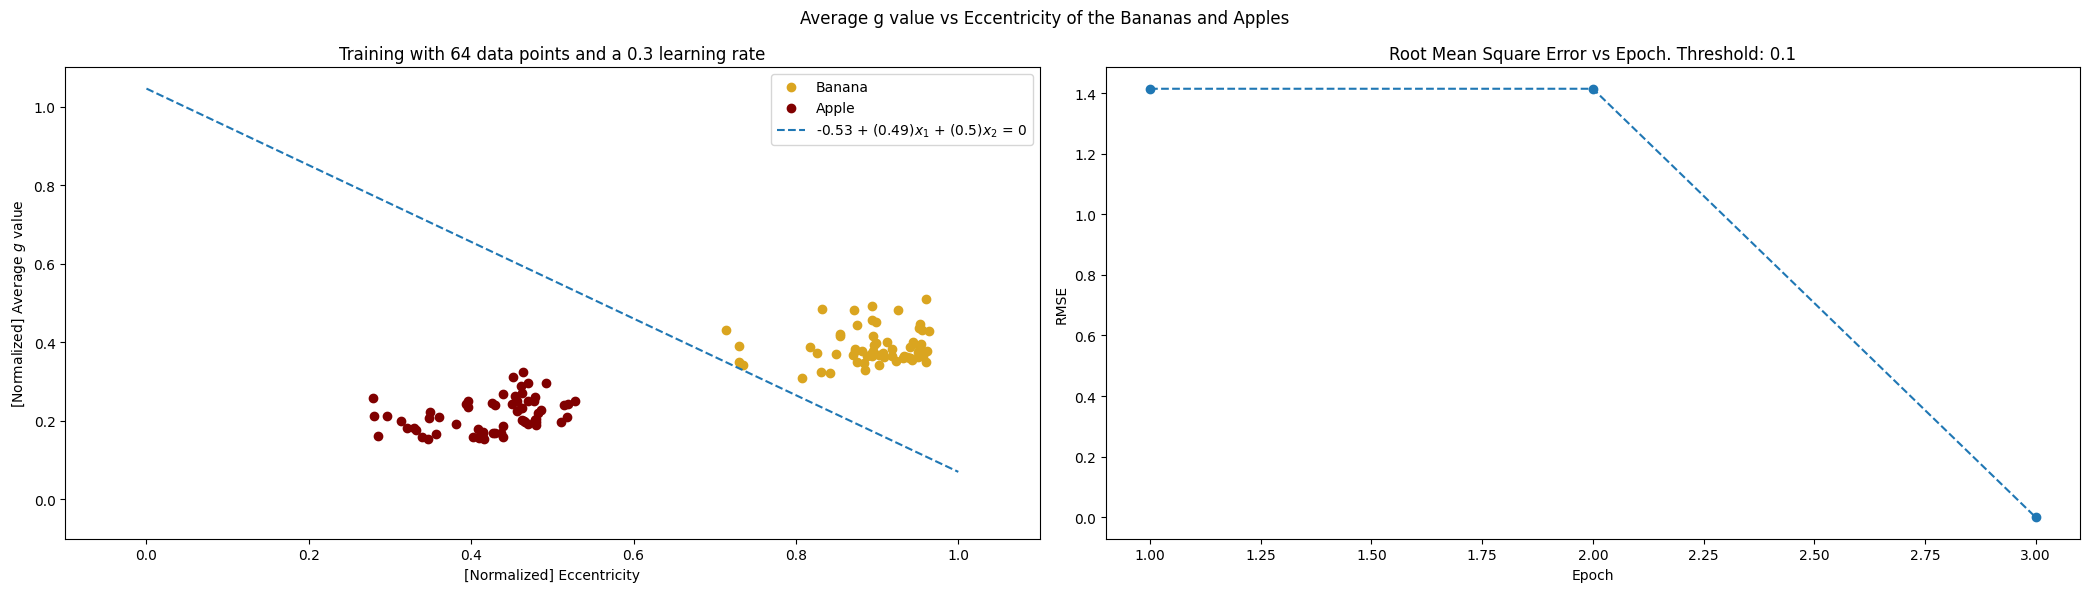

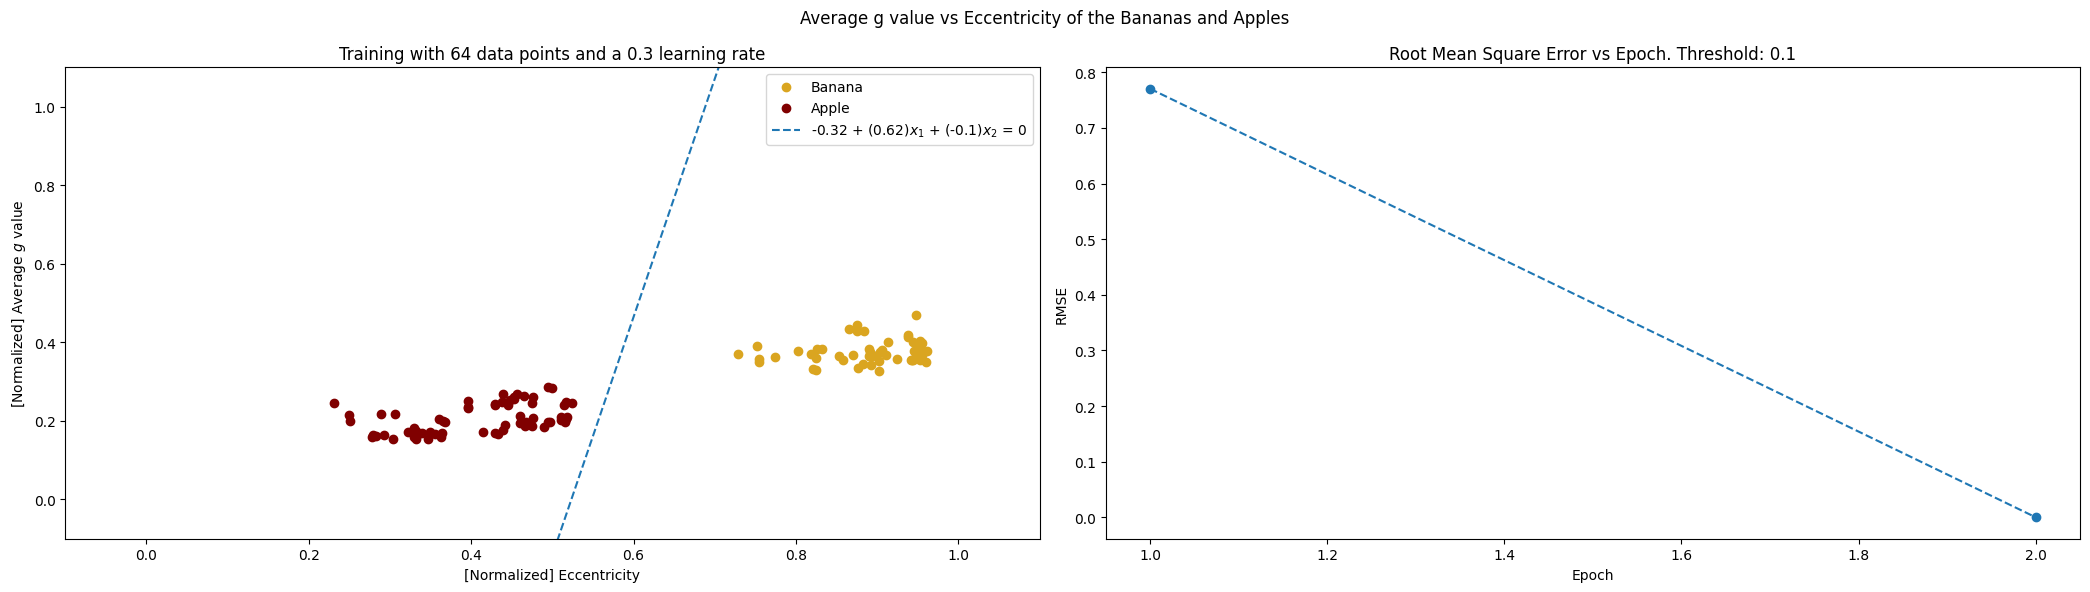

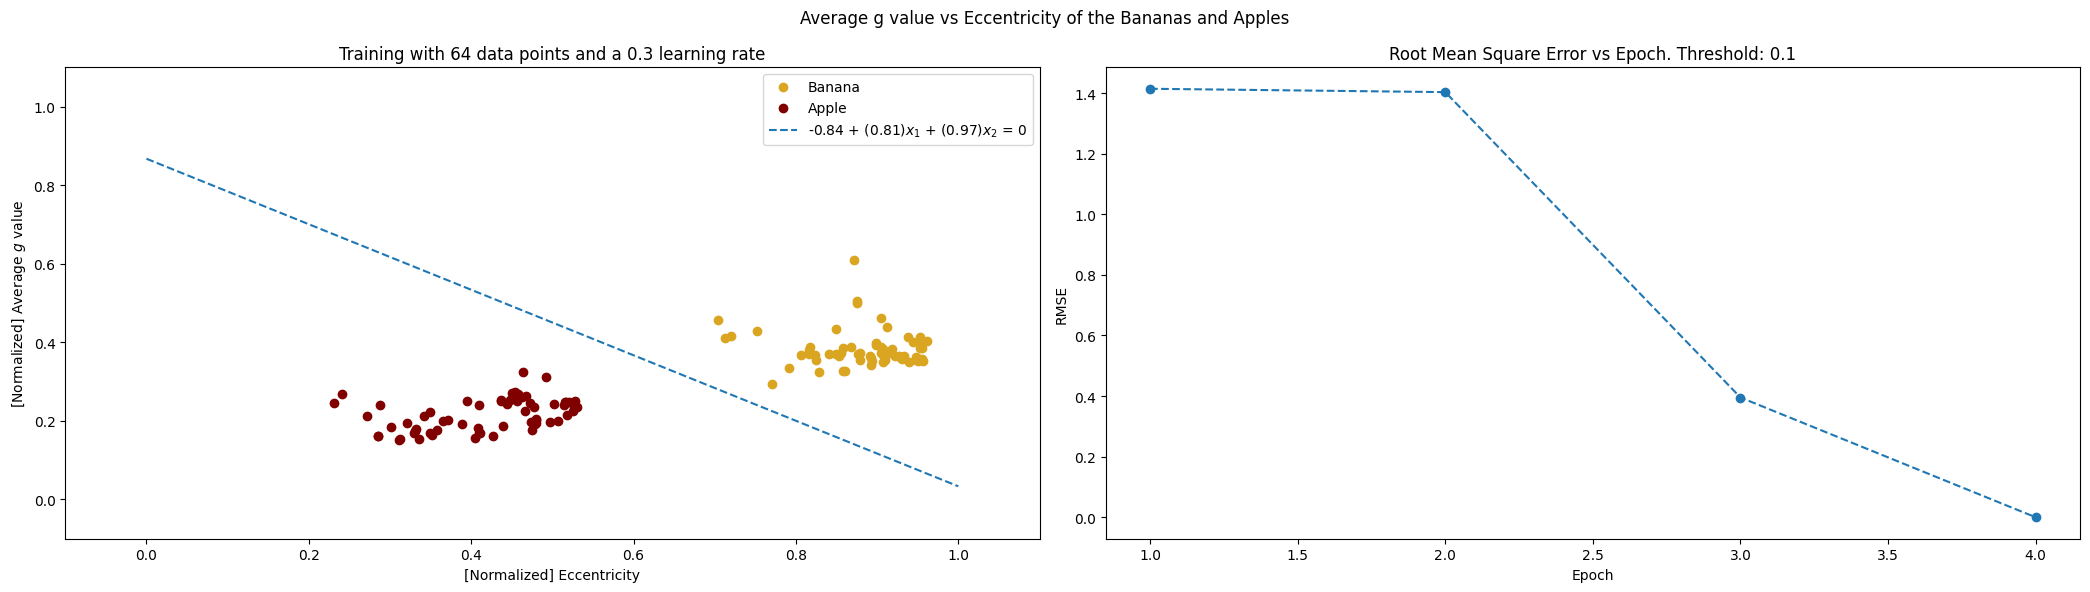

In [70]:
# Extracting the data and normalizing it
banana_data, apple_data = get_features('Banana data.csv', 'Apple data.csv', ['eccentricity', 'ave_g'])
norm_banana_data, norm_apple_data = normalize_data(banana_data, apple_data)

# Setting parameters for perceptron model
threshold = 0.1
learning_rate = 0.3
train_data = 64
test_data = 10
n = 3
banana_label = 1
apple_label = -1
title = 'Average g value vs Eccentricity of the Bananas and Apples'

# Applying perceptron algorithm n times
for i in range(0, n):

    # Splitting into training and testing data:
    banana_train, banana_test, apple_train, apple_test = train_test_split(norm_banana_data, norm_apple_data, train_size= train_data, test_size = test_data)

    # machine learning starts here
    omega_initial = initialize_omega(3)
    omega, RMSE = start_learning_perceptron(banana_train, apple_train, banana_label, apple_label, 'Banana', 'Apple', title, omega_initial, learning_rate, error_threshold = threshold)

## Testing out the parameters
Now that I know my code is working, I will now investigate the different parameters. The parameters that I will test are:
1. Data points
2. Learning rate

### 1.) Data points

I'll plot the graphs of only using 8, 16, 32, 64, and 126 data points. I'll use a learning rate of $0.25$ and an error threshold of $0.1$.

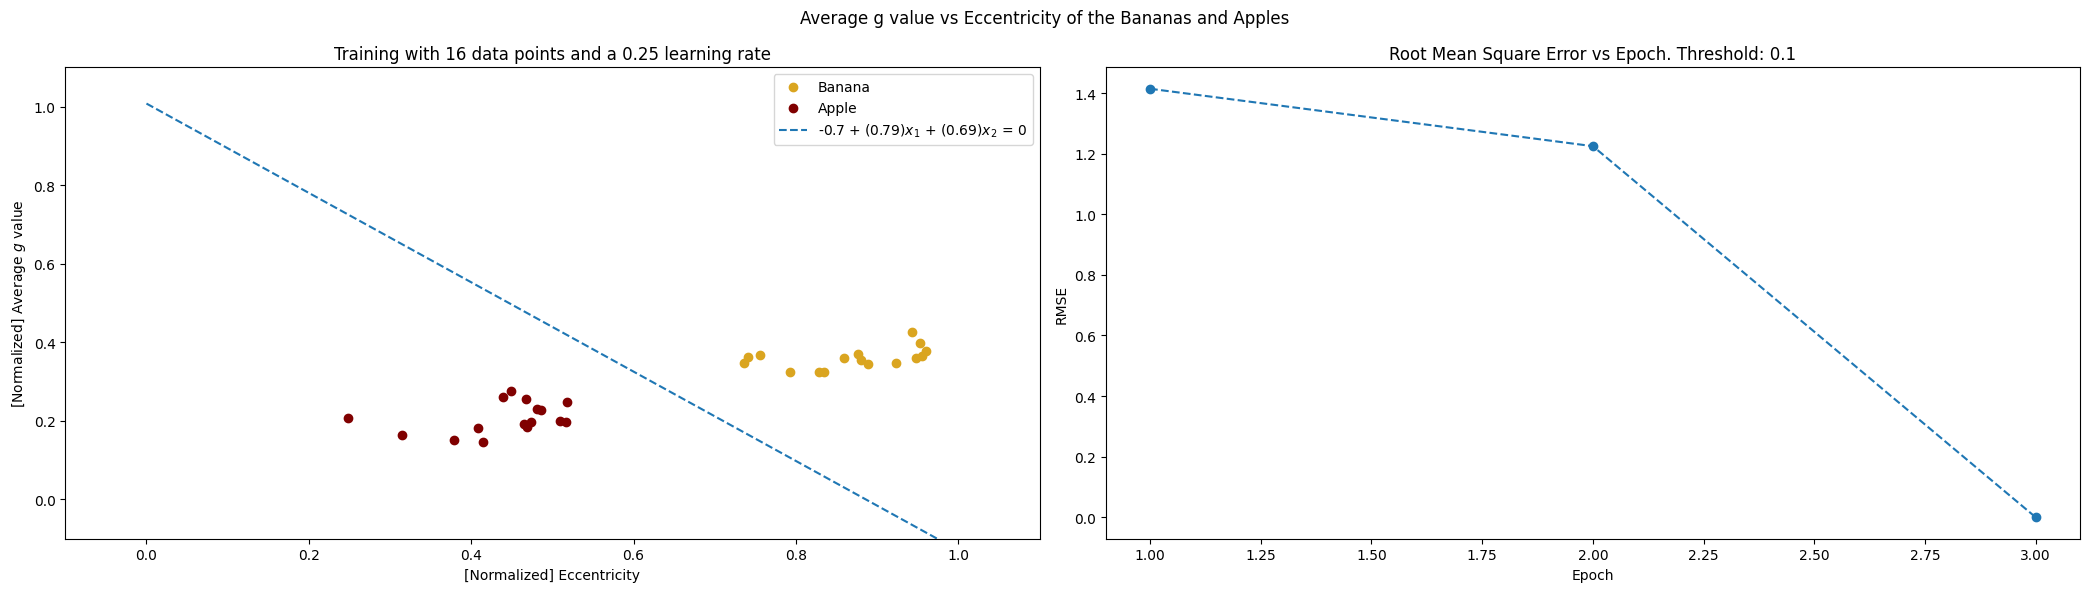

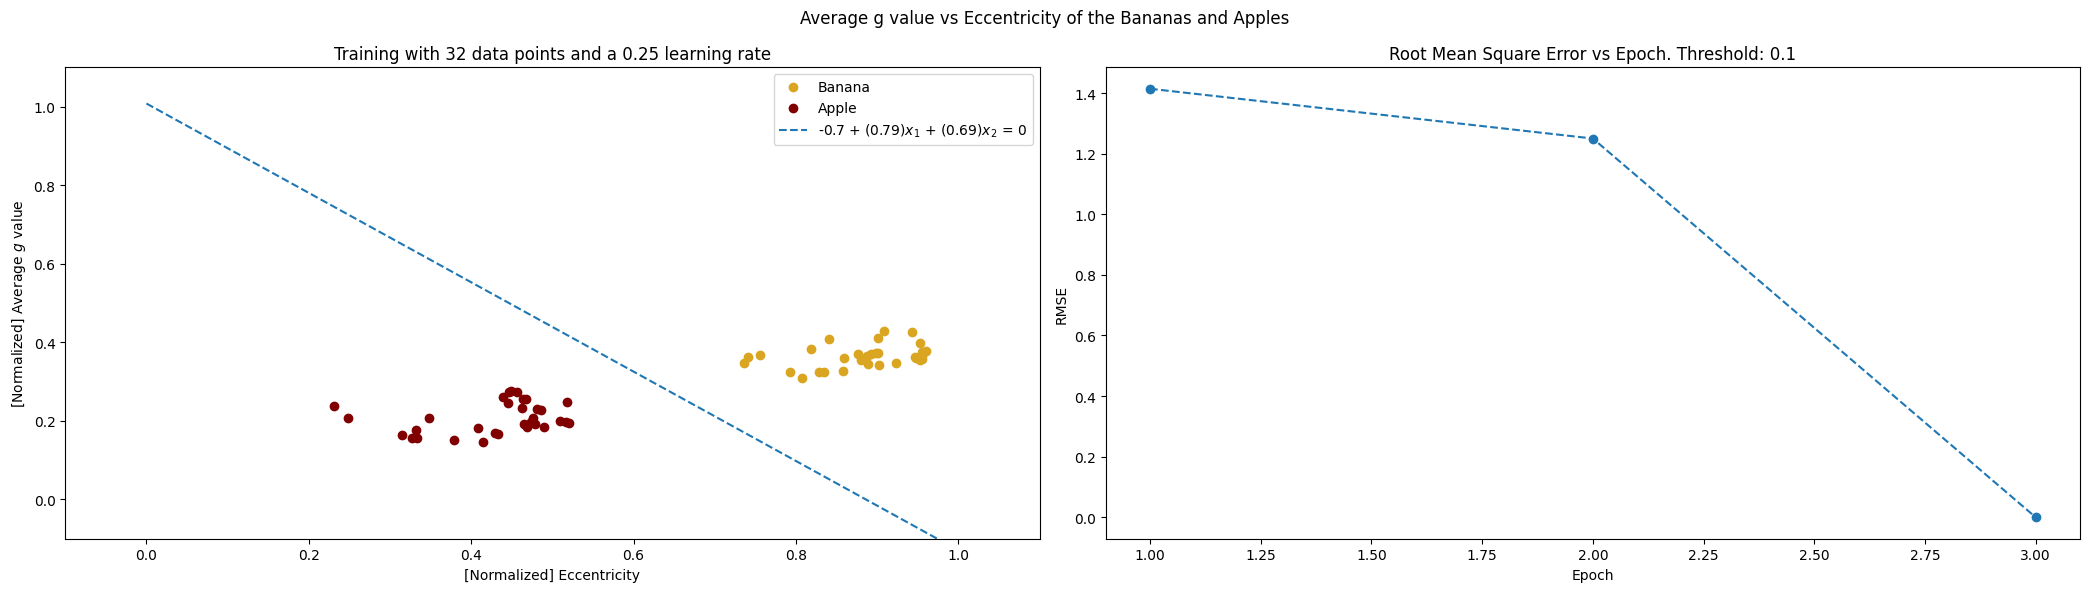

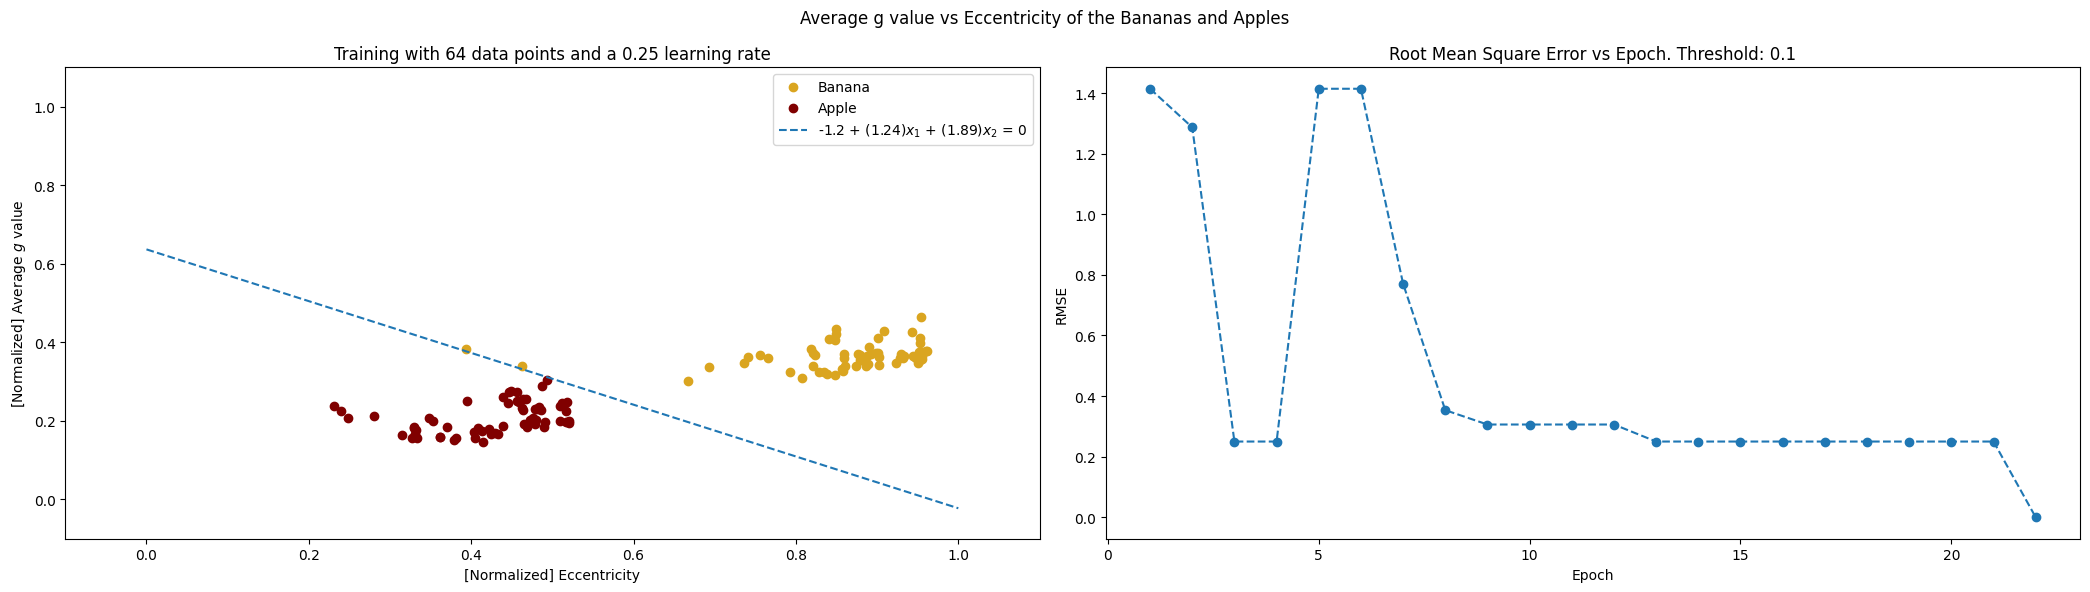

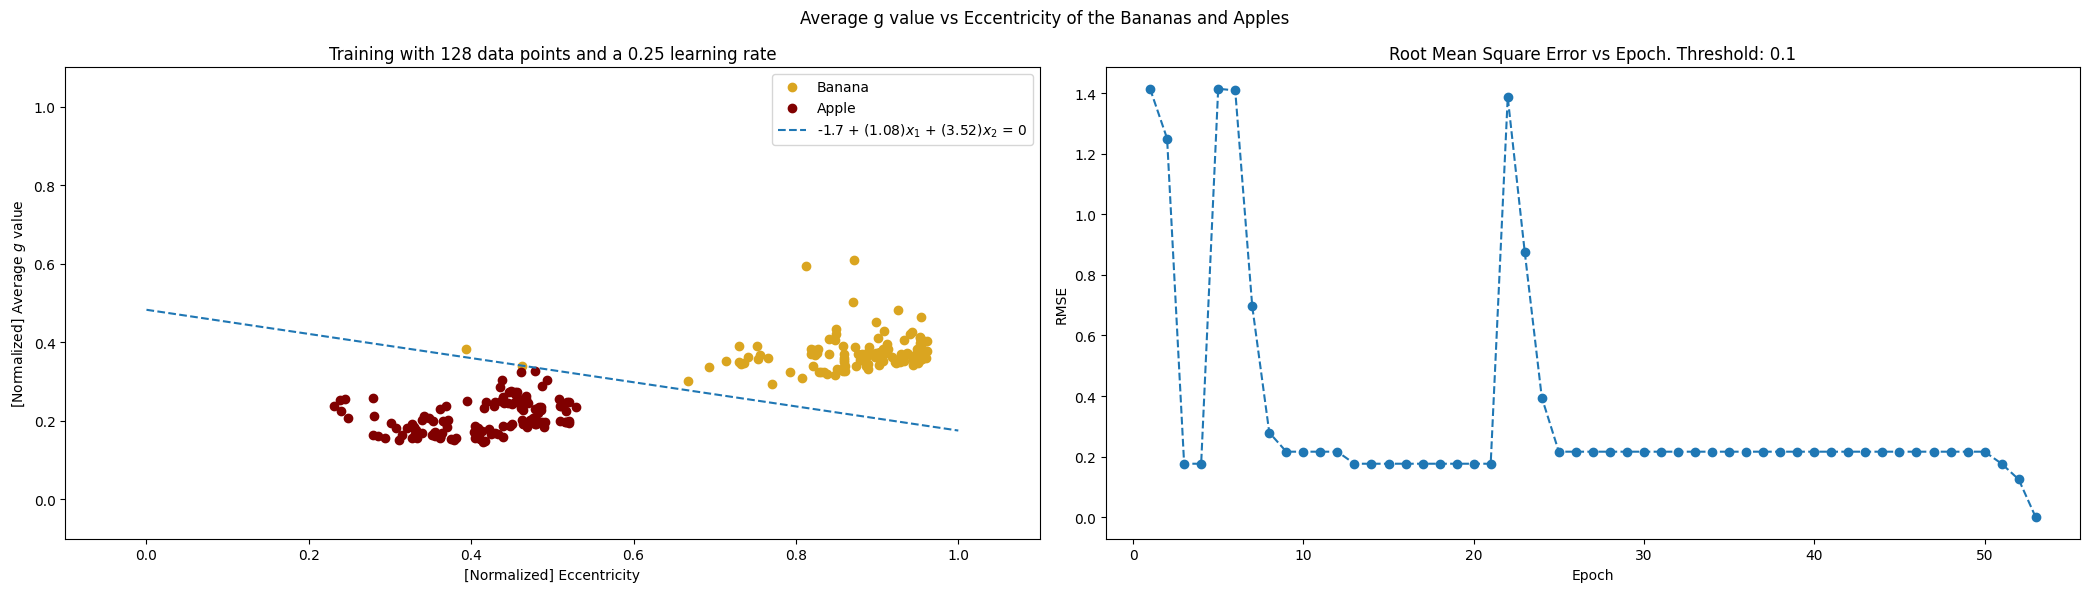

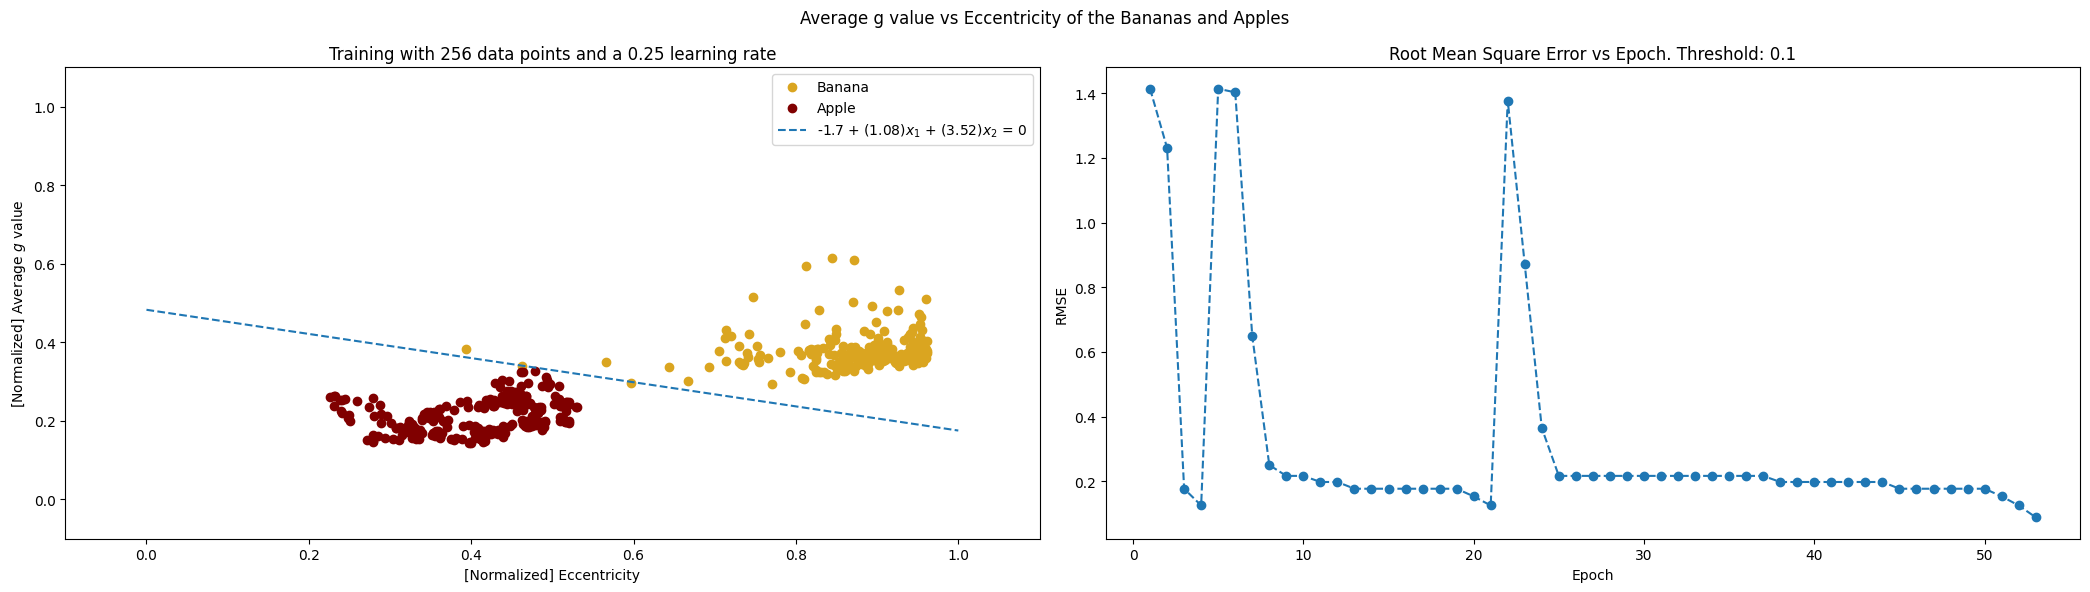

In [21]:
# Setting parameters for perceptron model
threshold = 0.1
learning_rate = 0.25
train_data = np.array([16,32,64,128, 256])
test_data = 10
omega_initial = np.array([0.8,0.8,0.8])
banana_label = 1
apple_label = -1
title = 'Average g value vs Eccentricity of the Bananas and Apples'

# Applying perceptron algorithm
for i in train_data:
    # Splitting into training and testing data:
    banana_train, banana_test, apple_train, apple_test = train_test_split(norm_banana_data, norm_apple_data, train_size= i, test_size = test_data, random_state = 1)

    # machine learning starts here
    omega, RMSE = start_learning_perceptron(banana_train, apple_train, banana_label, apple_label, 'Banana', 'Apple', title, omega_initial, learning_rate, error_threshold = threshold)


### 2.) Learning rate

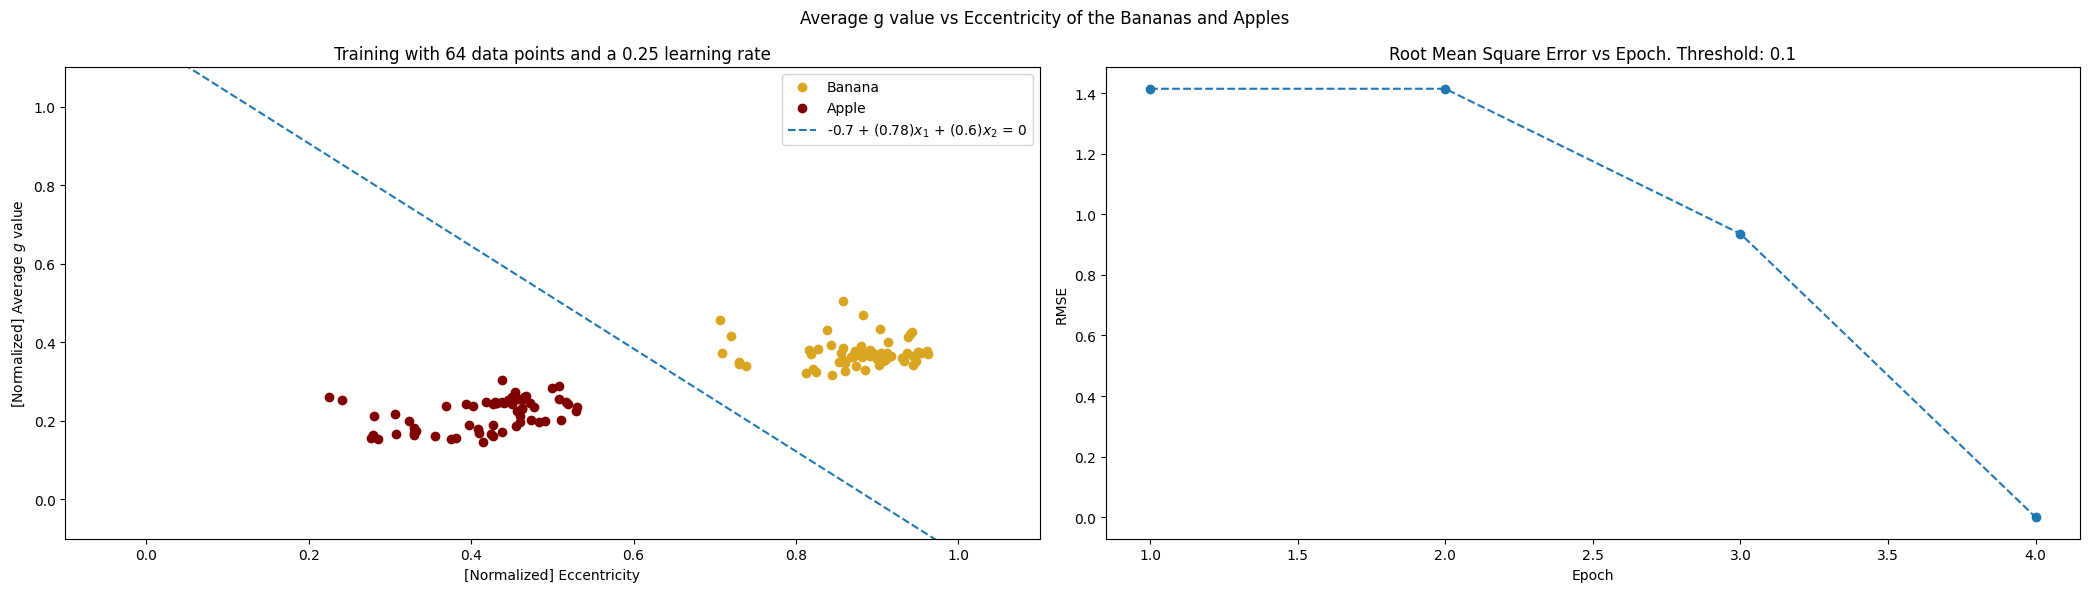

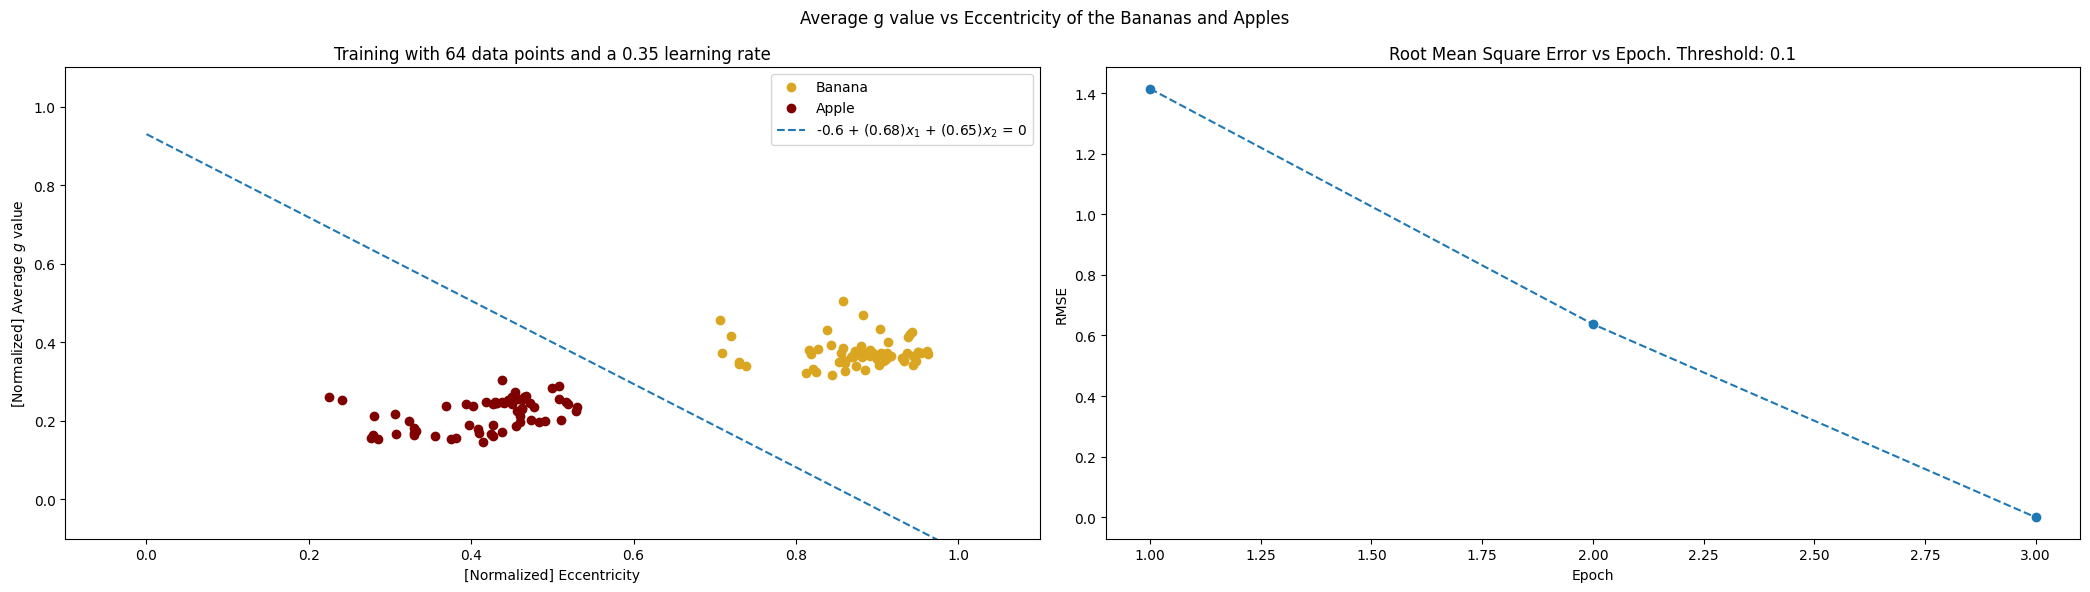

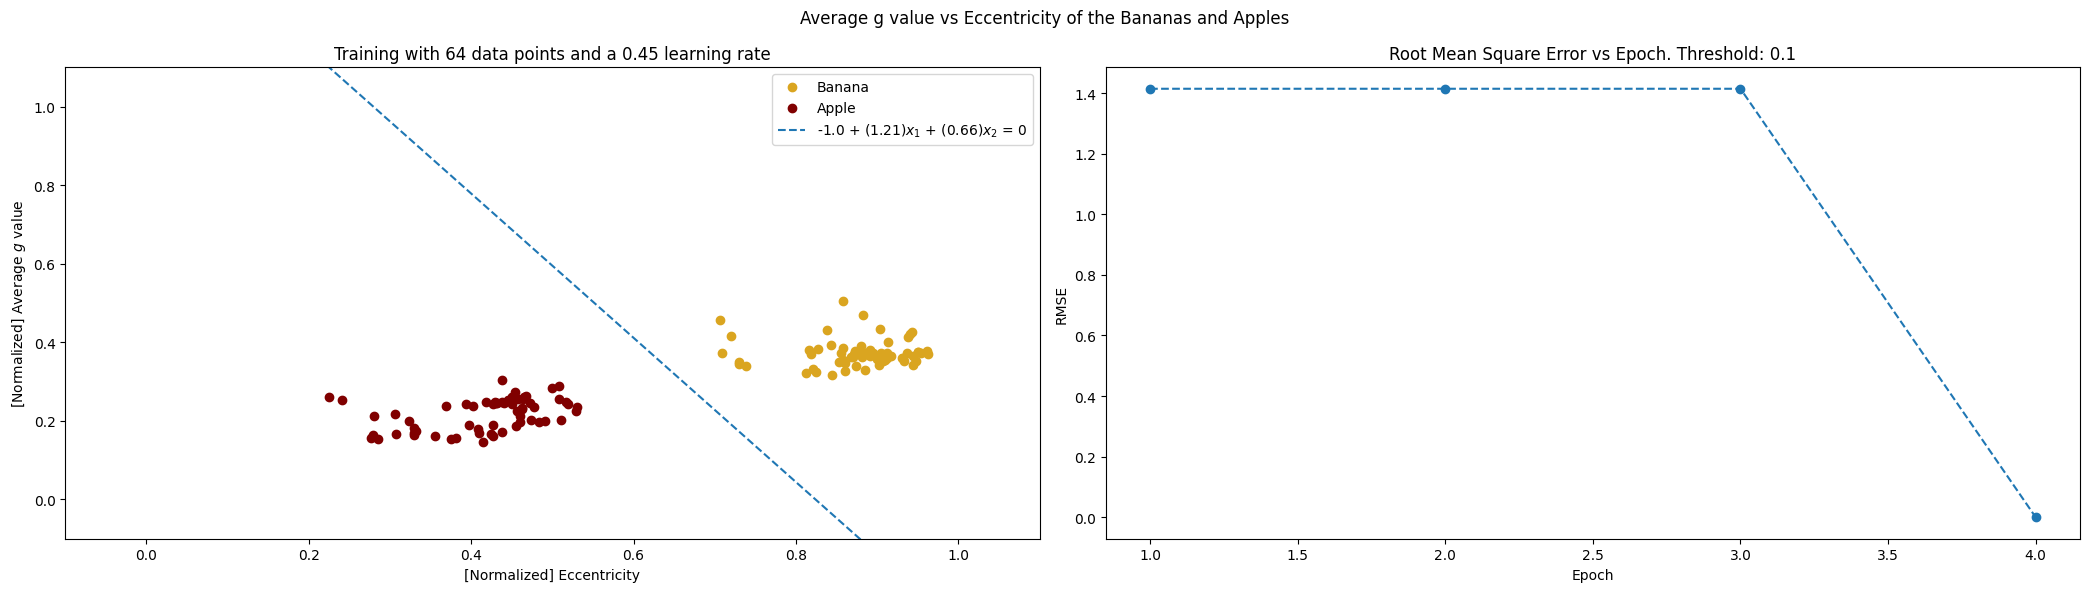

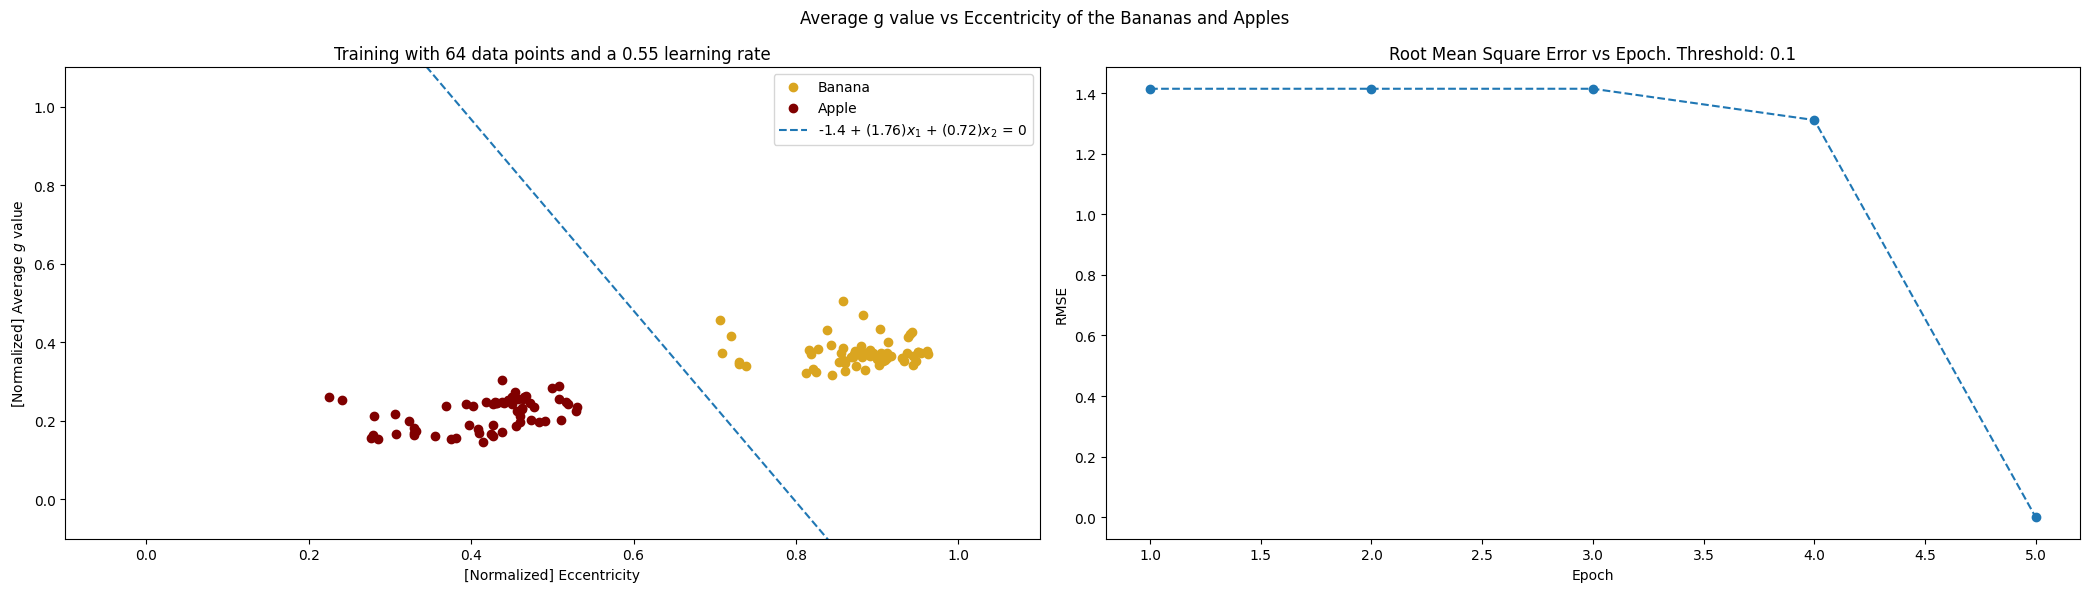

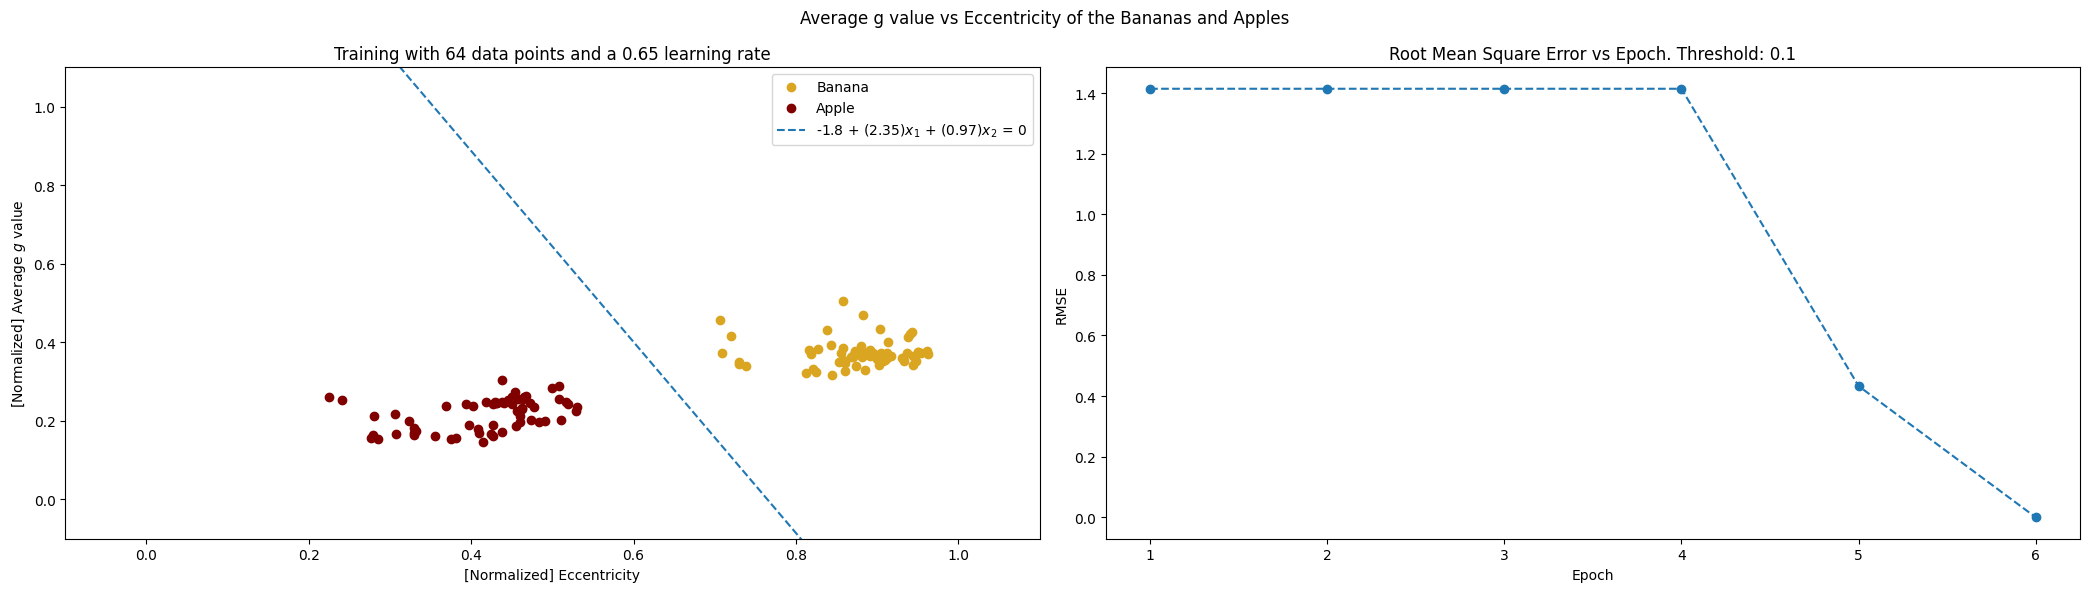

In [22]:
# Setting parameters for perceptron model
threshold = 0.1
learning_rate = np.array([0.25, 0.35, 0.45, 0.55, 0.65])
train_data = 64
test_data = 10
n = 5
omega_initial = np.array([0.8,0.8,0.8])
banana_label = 1
apple_label = -1
title = 'Average g value vs Eccentricity of the Bananas and Apples'

# Splitting into training and testing data:
banana_train, banana_test, apple_train, apple_test = train_test_split(norm_banana_data, norm_apple_data, train_size= train_data, test_size = test_data, random_state = 10)

# Applying perceptron algorithm n times
for i in learning_rate:
    # machine learning starts here
    omega_, RMSE= start_learning_perceptron(banana_train, apple_train, banana_label, apple_label, 'Banana', 'Apple', title, omega_initial, i, error_threshold = threshold)


## Now testing my model

In [43]:
def perceptron_test(filename, features, true_label, label1, label2, text_label1, text_label2, omega, bias, title):
    folder = '/test images/'
    image = cv2.imread(image_repository + folder + filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    overall_data = pd.DataFrame(columns = ['area', 'eccentricity', 'ave_r', 'ave_g', 'ave_b'])

    commands = [
                ['convert_ncc'],
                ['invert'],
                ['median_blur', 15],
                ['grayscale'],
                ['simple_binarize', 80],
                ['fill_holes'],
                ['apply_mask'],
                ['separate_RGB'],
                ['average_rgb'],
                ['get_mask'],
                ['save', ('area','centroid', 'bbox', 
                    'perimeter', 'eccentricity' , 
                    'orientation','axis_major_length',
                    'axis_minor_length'), 1000 ]
        ]
        
    data, ave_R, ave_G, ave_B = morphing_time(folder+filename, commands)
    new_data = [data.iloc[0]['area'], data.iloc[0]['eccentricity'], ave_R, ave_G, ave_B]
    overall_data.loc[len(overall_data)] = new_data
    test_data = overall_data.loc[:, features]

    test_data.loc[0,'ave_g'] *= 1/255
    test_data = get_vector(test_data, label = true_label, bias = bias)
    test_data.insert(len(test_data.iloc[0]),'Classification', None)

    a = np.sum(omega*test_data.iloc[:,1:4], axis = 1)
    z = g(a)


    test_data.loc[z == label1,'Classification'] = text_label1
    test_data.loc[z == label2,'Classification'] = text_label2
    omega_0, omega_1, omega_2 = omega[0], omega[1], omega[2]
    line_values = get_line(np.linspace(0,1,1000), omega)
    fig, ax = plt.subplots(1,2, figsize = (21, 6))
    fig.suptitle(title)
    ax[0].imshow(image)
    ax[0].set_title(filename + " is: " + test_data.loc[0,'Classification'])
    
    ax[1].scatter(test_data.iloc[:,2], test_data.iloc[:,3], label = filename)
    ax[1].plot(np.linspace(0,1,1000), line_values, label = str(np.round(omega_0,2)) + ' + (' + str(np.round(omega_1,2)) + ')$x_1$ + (' + str(np.round(omega_2,2)) + ')$x_2$ = 0', linestyle = '--' )
    ax[1].set_xlabel('[Normalized] Eccentricity')
    ax[1].set_ylabel('[Normalized] Average $g$ value')
    ax[1].set_title('The average $g$ value vs eccentricity of the image.')
    ax[1].set_xlim([-0.1, 1.1])
    ax[1].set_ylim([-0.1, 1.1])
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()



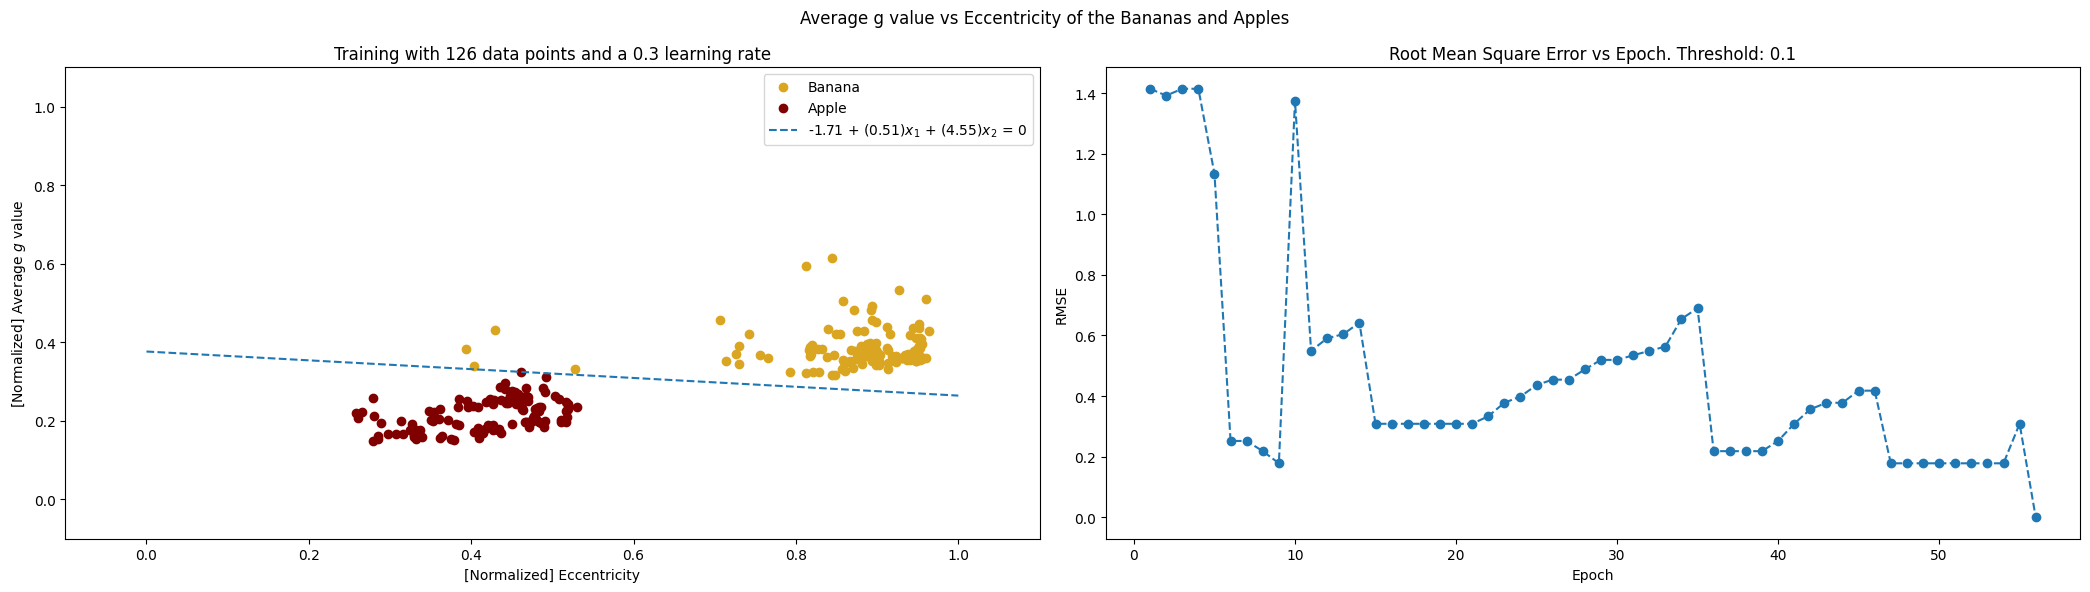

In [39]:
# Extracting the data and normalizing it
# Setting parameters for perceptron model
threshold = 0.1
learning_rate = 0.3
train_data = 126
test_data = 10
banana_label = 1
apple_label = -1
bias = 1
title = 'Average g value vs Eccentricity of the Bananas and Apples'

# Applying perceptron algorithm

# Splitting into training and testing data:
banana_train, banana_test, apple_train, apple_test = train_test_split(norm_banana_data, norm_apple_data, train_size= train_data, test_size = test_data, random_state = 0)

# machine learning starts here
omega_initial = initialize_omega(3)
omega, RMSE = start_learning_perceptron(banana_train, apple_train, banana_label, apple_label, 'Banana', 'Apple', title, omega_initial, learning_rate, error_threshold = threshold)




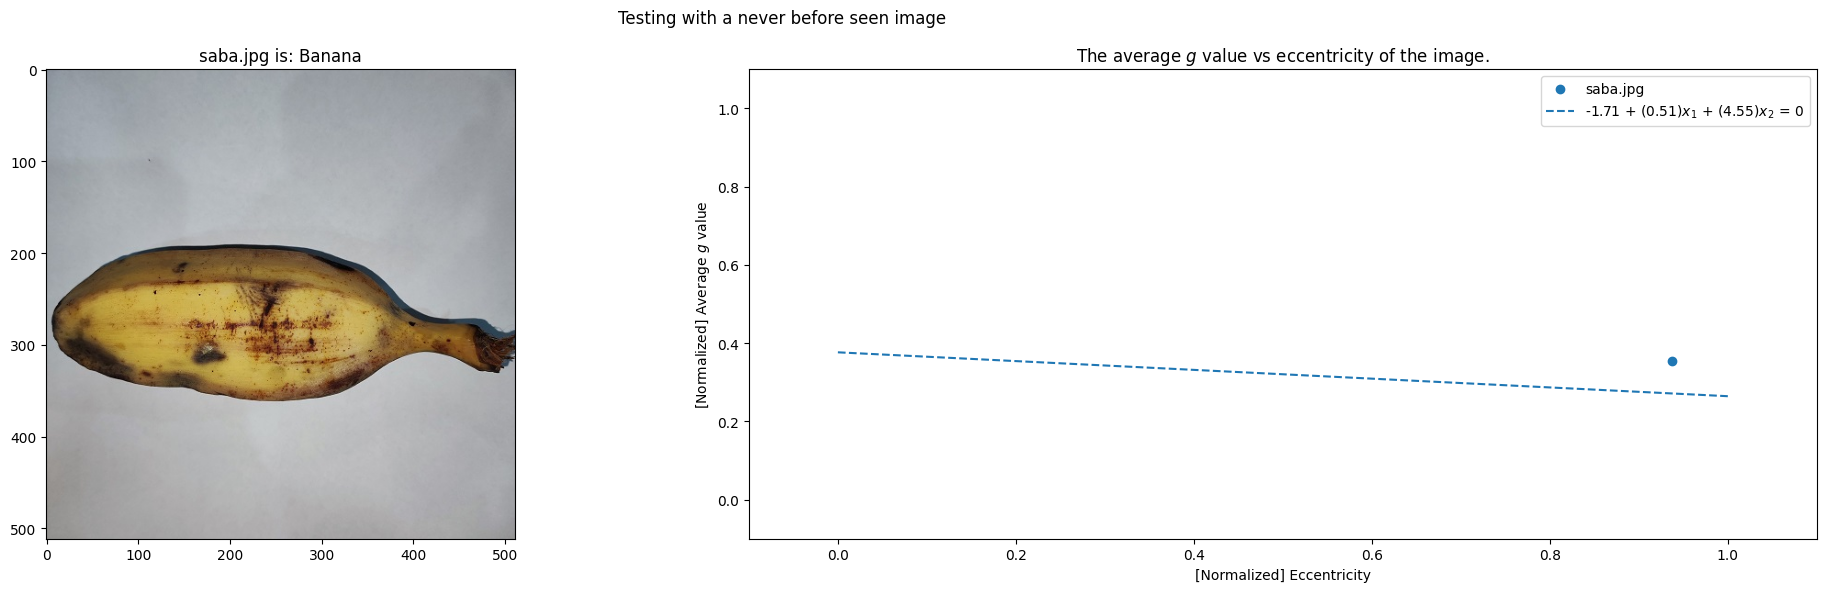

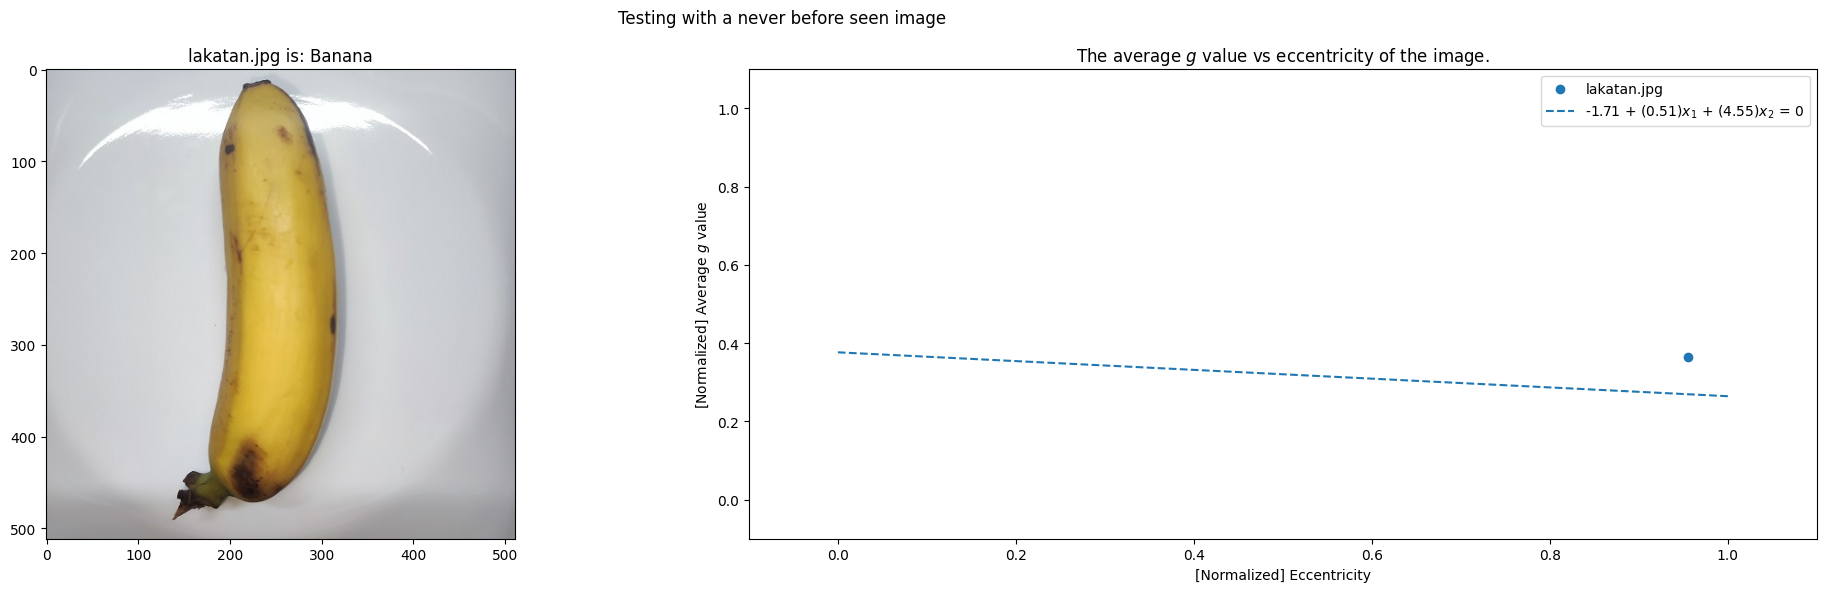

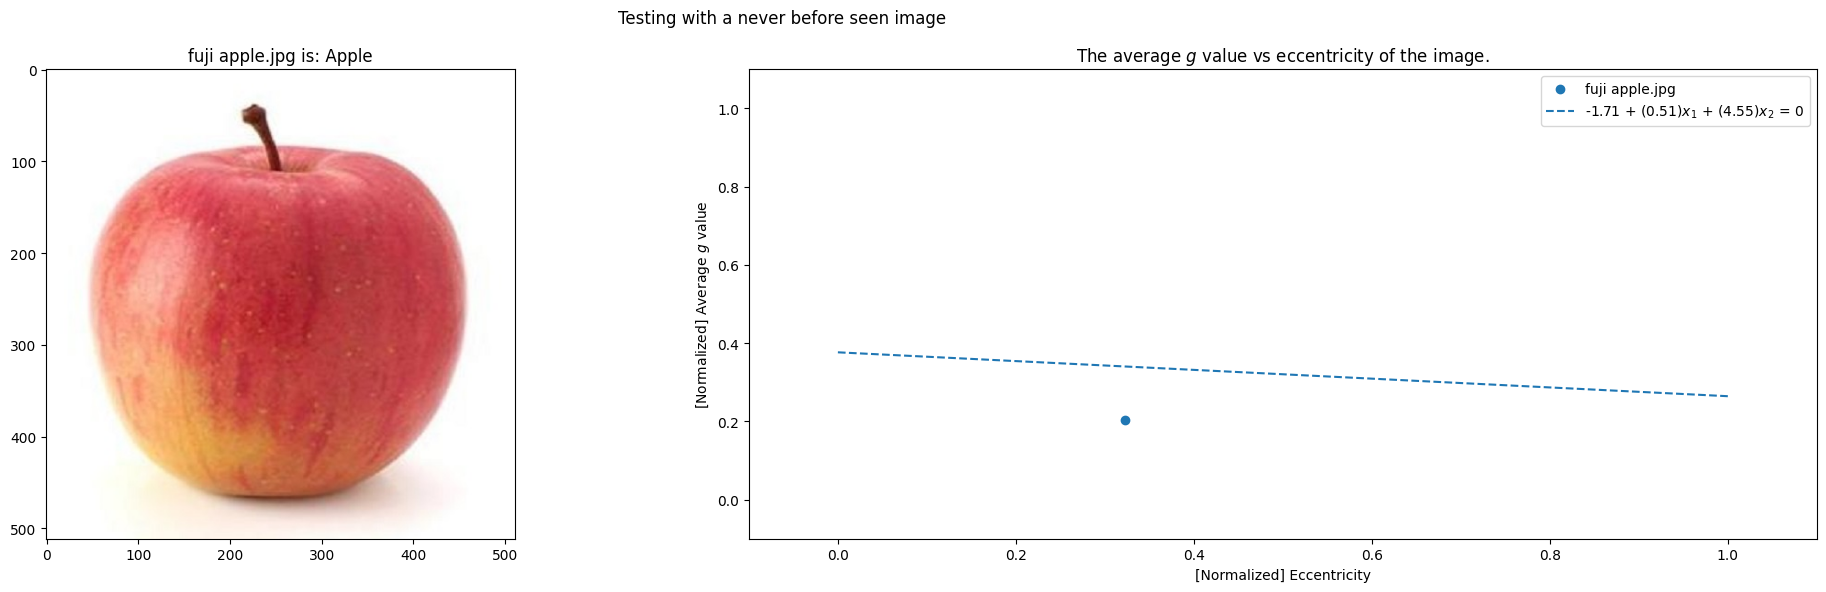

In [44]:
perceptron_test('saba.jpg', ['eccentricity', 'ave_g'], 1, 1, -1, 'Banana', 'Apple', omega, 1, 'Testing with a never before seen image')
perceptron_test('lakatan.jpg', ['eccentricity', 'ave_g'], 1, 1, -1, 'Banana', 'Apple', omega, 1, 'Testing with a never before seen image')
perceptron_test('fuji apple.jpg', ['eccentricity', 'ave_g'], 1, 1, -1, 'Banana', 'Apple', omega, 1, 'Testing with a never before seen image')

# Logistic Regression

In [165]:
def create_plots_logreg(data_input1, data_input2, textlabel1, textlabel2, title, omega, learning_rate, epoch, beta):
    ripe_a = np.sum(data_input1.iloc[:, 1:]*omega, axis = 1)
    unripe_a = np.sum(data_input2.iloc[:, 1:]*omega, axis = 1)
    
    min_x = np.min((np.min(ripe_a), np.min(unripe_a)))
    max_x = np.max((np.max(ripe_a), np.max(unripe_a)))
    line_a = np.linspace(min_x, max_x, int(max_x - min_x))

    fig, ax = plt.subplots(figsize = (15, 6))
    # Plotting the data
    ax.plot(line_a, g(line_a), label = 'β = '+ str(beta), linestyle = '--', alpha= 0.7)
    ax.scatter(ripe_a, g(ripe_a), label = textlabel1, color = 'indigo')
    ax.scatter(unripe_a, g(unripe_a), label = textlabel2, color = 'green')

    
    # Labelling the plots
    ax.set_xlabel('$a$')
    ax.set_ylabel('$\phi(a) = \dfrac{ 1 }{1+\exp[-βa]}$')
    ax.set_title(str(len(data_input1.iloc[:,0])) + ' data points, ' + str(learning_rate) + ' learning rate, and ' + str(epoch) + ' epochs')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [195]:
def start_learning_logreg(data_input1, data_input2, label1, label2, textlabel1, textlabel2, title, omega_input, learning_rate, error_threshold = 0.001, bias = 1, epochs = 50, beta = 1):
    # Creating copies so I won't change the input
    data_1 = data_input1.copy()
    data_2 = data_input2.copy()
    omega = omega_input.copy()

    # Turning the data into vectors:
    data_1 = get_vector(data_1, label = label1, bias = bias)
    data_2 = get_vector(data_2, label = label2, bias = bias)
    all_data = pd.concat([data_1, data_2])

    for i in range(epochs):
        for i in range(len(all_data)):
            a = np.sum(omega*all_data.iloc[i,1:])
            z = g(a)
            E = (all_data.iloc[i, 0] - z)
            omega += calculate_weight_change(all_data.iloc[i,1:], E, learning_rate)  

    create_plots_logreg(data_input1, data_input2, textlabel1, textlabel2, title, omega, learning_rate, epochs, beta)
    return omega

In [26]:
def get_features3(filename1, filename2, features):
    df1 = pd.read_csv(data_repository + filename1)
    df2 = pd.read_csv(data_repository + filename2)

    df1_features = df1.loc[:,features]
    df2_features = df2.loc[:,features]

    return df1_features, df2_features

In [47]:
ripe_features, unripe_features = get_features('Avocado ripe data.csv', 'Avocado unripe data.csv', ['ave_r','ave_g', 'ave_b'])

to_show = pd.DataFrame(columns = ['ripe_ave_R' , 'unripe_ave_R','ripe_ave_G' , 'unripe_ave_G','ripe_ave_B', 'unripe_ave_B' ])

for i in range(10):
    to_show.loc[len(to_show)] = [ripe_features.iloc[i,0], unripe_features.iloc[i,0], ripe_features.iloc[i,1], unripe_features.iloc[i,1], ripe_features.iloc[i,2], unripe_features.iloc[i,2]]
display(to_show)

,ripe_ave_R,unripe_ave_R,ripe_ave_G,unripe_ave_G,ripe_ave_B,unripe_ave_B
0,73.299482,57.157854,73.981083,61.323933,76.691557,27.994516
1,72.949423,45.046241,73.641577,48.525937,76.248507,24.410919
2,80.638743,44.623641,81.711236,48.301436,85.313733,23.954193
3,72.779570,44.779740,73.590601,48.187270,76.001195,24.072191
4,78.065626,44.542763,79.069628,48.242454,82.722489,24.038119
5,72.929299,44.163928,73.475335,47.804949,75.989615,24.041175
6,77.610800,43.921058,78.451400,47.732098,82.197200,23.587531
7,77.328463,43.798456,78.047438,47.456178,81.782826,23.474131
8,76.531600,43.537527,77.288800,47.309666,80.705400,23.229018
9,72.773743,43.375966,73.536712,46.912481,75.918196,23.032264


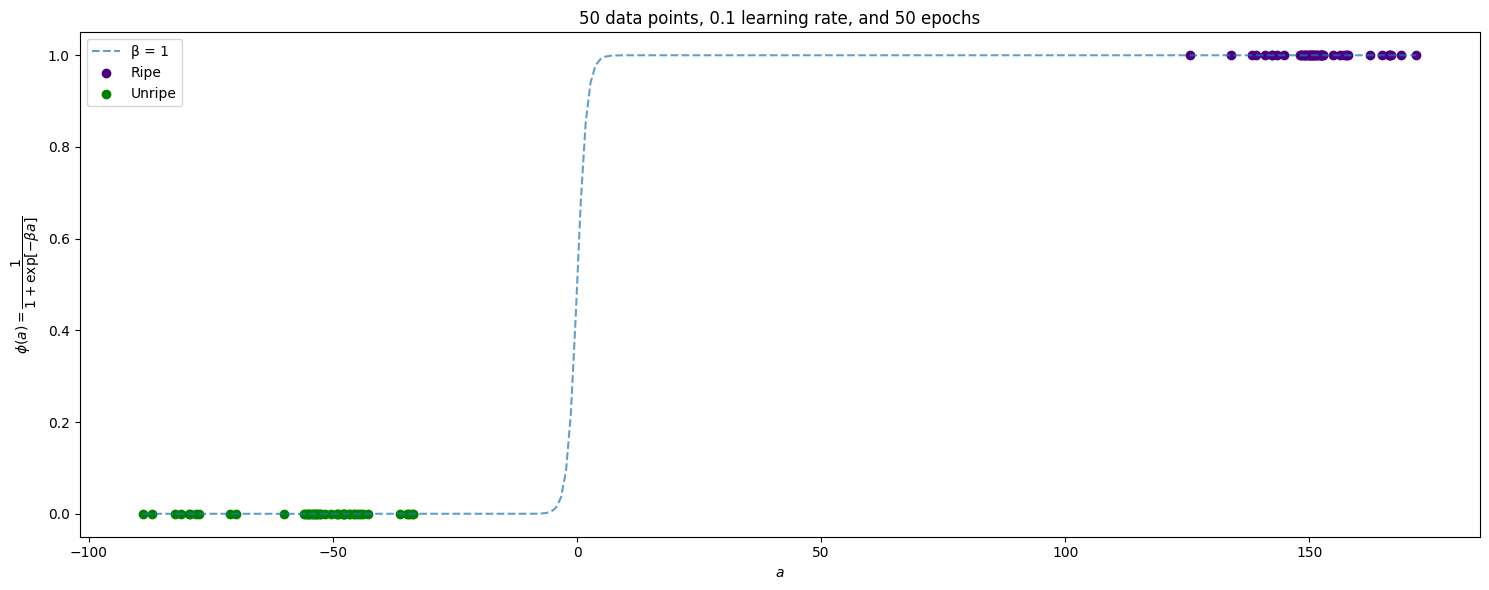

In [196]:
def g(a, beta = 1):
    return (1)/(1+np.exp(-beta*a))


# Extracting the data and normalizing it
features = ['ave_r','ave_g', 'ave_b']
ripe_data, unripe_data = get_features('Avocado ripe data.csv', 'Avocado unripe data.csv', features)

# Normalizing the data
norm_ripe_data, norm_unripe_data = ripe_data.loc[:, features]/255, unripe_data.loc[:, features]/255

# Setting parameters for logarithmic regression model
learning_rate = 0.1
train_data = 50
test_data = 20
unripe_label = 0
ripe_label = 1
title = 'Logistic Regression'


# Splitting into training and testing data:
ripe_train, ripe_test, unripe_train, unripe_test = train_test_split(ripe_data, unripe_data, train_size= train_data, test_size = test_data, random_state = 13)

# machine learning starts here
omega_initial = initialize_omega(4)
omega = start_learning_logreg(ripe_train, unripe_train, ripe_label, unripe_label, 'Ripe', 'Unripe', title, omega_initial, learning_rate, error_threshold = threshold)

## Now testing my algorithm using neverbefore seen data

In [198]:
def logreg_test(filename, features, omega, bias, title, beta):
    folder = '/test images/'
    image = cv2.imread(image_repository + folder + filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    overall_data = pd.DataFrame(columns = ['ave_r', 'ave_g', 'ave_b'])

    commands = [
                # ['convert_NCC'],
                ['invert'],
                ['median_blur', 15],
                ['grayscale'],
                ['simple_binarize', 50],
                ['fill_holes'],
                ['apply_mask'],
                ['separate_RGB'],
                ['average_rgb'],
                ['get_mask'],
                ['save', ('area','centroid', 'bbox', 
                        'perimeter', 'eccentricity' , 
                        'orientation','axis_major_length',
                            'axis_minor_length'), 2000 ]
            ]
        
    data, ave_R, ave_G, ave_B = morphing_time(folder+filename, commands)
    new_data = [ave_R, ave_G, ave_B]
    overall_data.loc[len(overall_data)] = new_data
    test_data = overall_data.loc[:, features]

    test_data.loc[0,features] *= 1/255

    test_data = get_vector(test_data, bias = bias, labelling = False)

    a = np.sum(omega*test_data.iloc[:,1:], axis = 1)
    z = g(a)
    x = np.linspace(-10,10,1000)


    fig, ax = plt.subplots(1,2, figsize = (21, 6))
    fig.suptitle(title)
    ax[0].imshow(image)
    ax[0].set_title(filename + " is: " + str(int(z.iloc[0]*100)) + "$\%$ ripe")
    
    ax[1].scatter(a, z, label = filename)
    ax[1].plot(x, g(x), label = 'β = '+ str(beta), linestyle = '--', alpha= 0.7 )
    ax[1].set_xlabel('$a$')
    ax[1].set_ylabel('$\phi(a) = \dfrac{ 1 }{1+\exp[-βa]}$')
    ax[1].set_title('$\omega_0$ = ' + str(np.round(omega[0], 3)) + ', $\omega_1$ = ' + str(np.round(omega[1], 3)) +', $\omega_2$ = ' + str(np.round(omega[2], 3)) +', $\omega_3$ = ' + str(np.round(omega[3], 3)))
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()



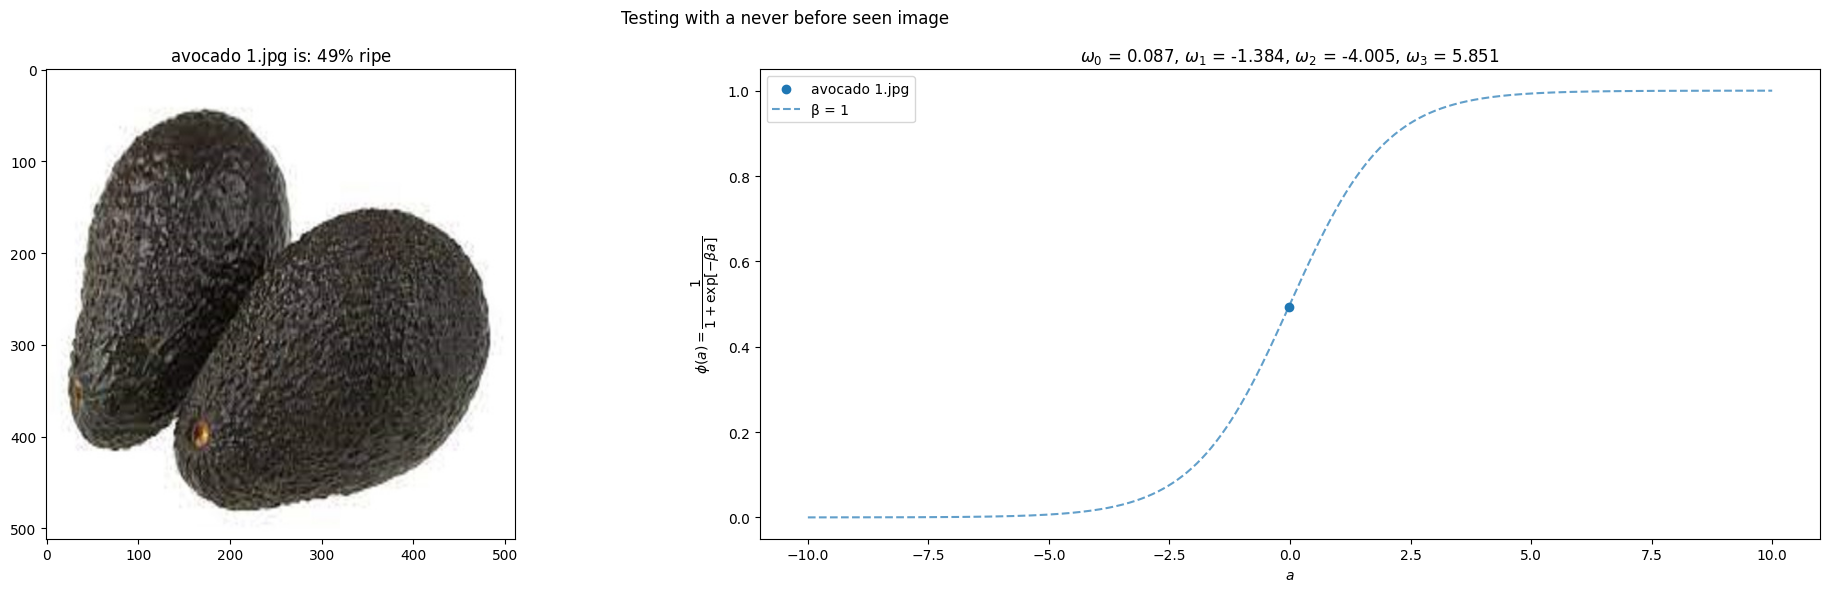

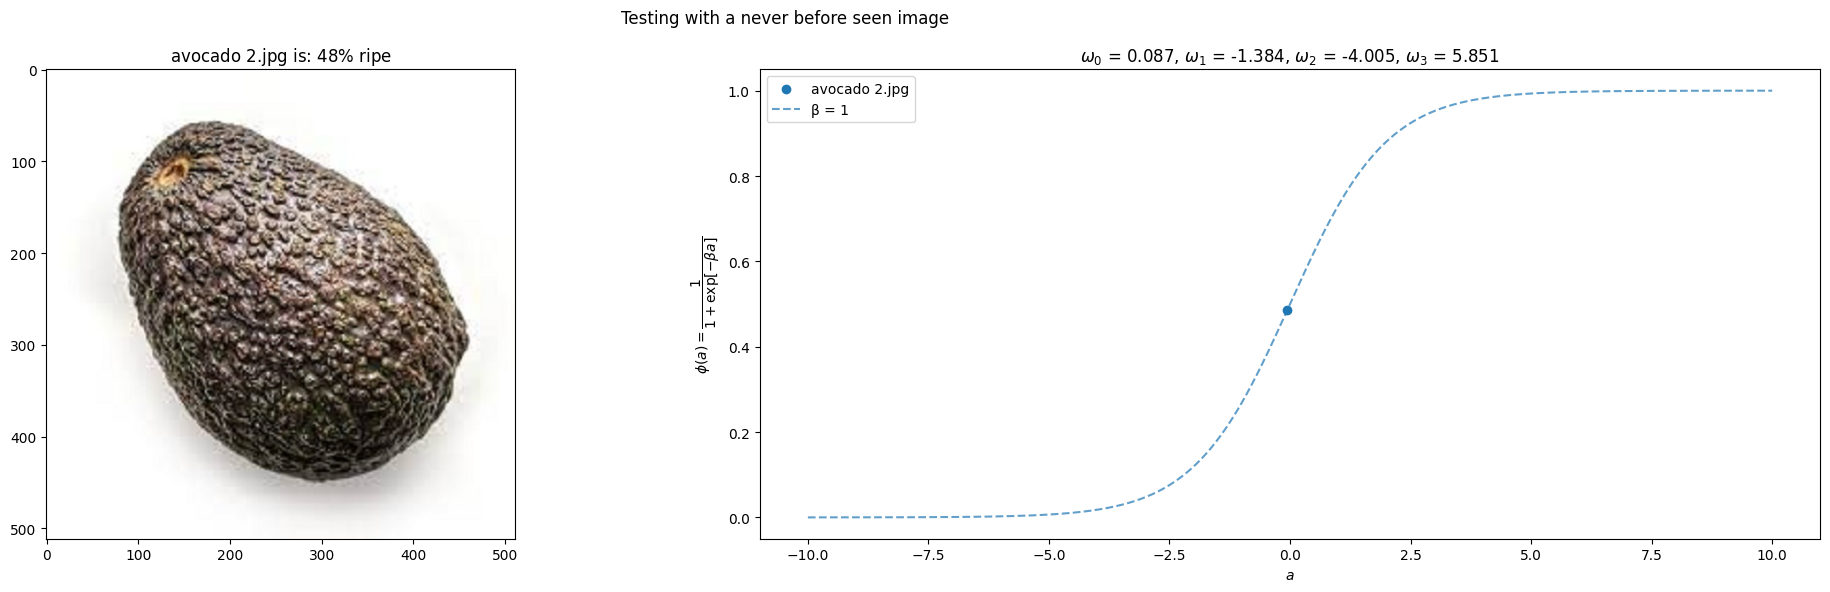

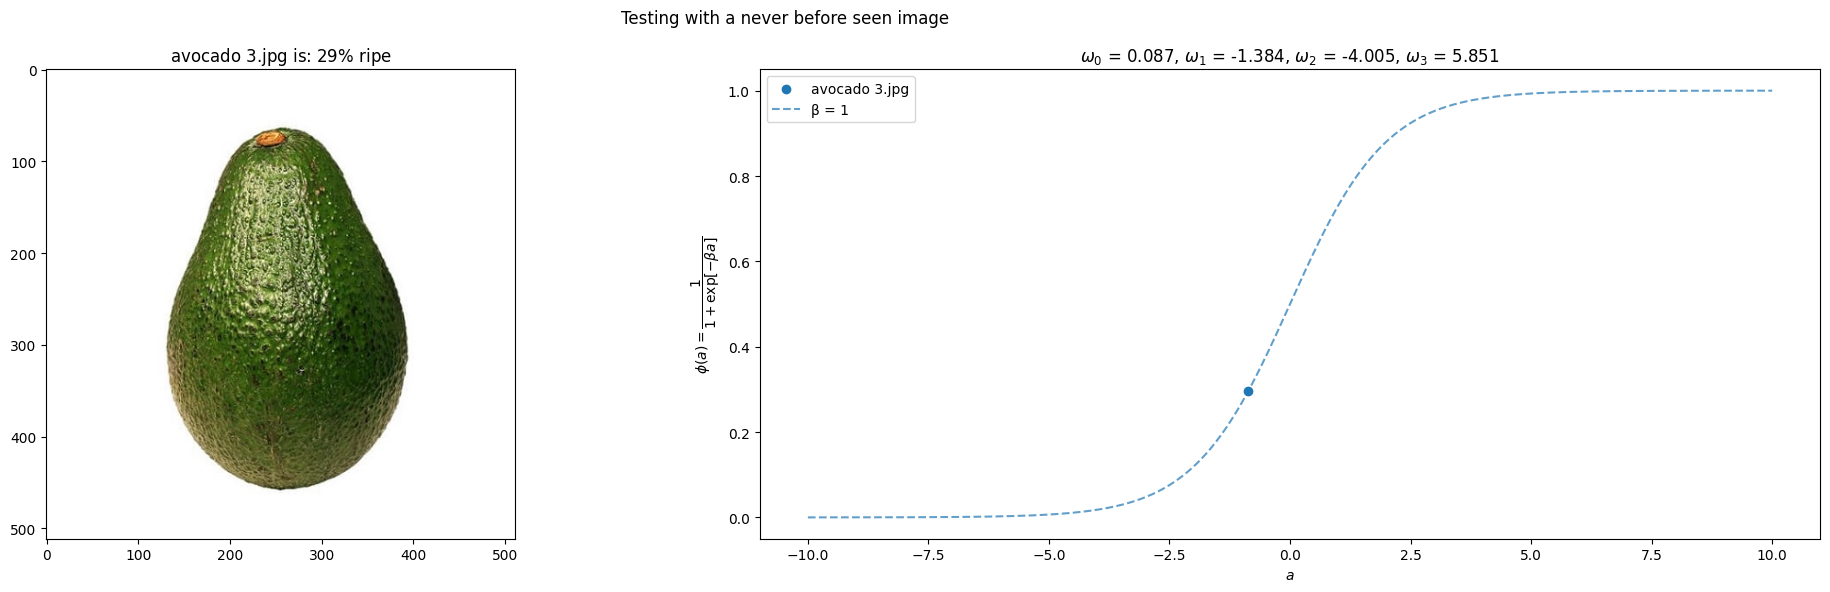

In [199]:
logreg_test('avocado 1.jpg', ['ave_r', 'ave_g', 'ave_b'], omega, 1, 'Testing with a never before seen image', 1)
logreg_test('avocado 2.jpg', ['ave_r', 'ave_g', 'ave_b'], omega, 1, 'Testing with a never before seen image', 1)
logreg_test('avocado 3.jpg', ['ave_r', 'ave_g', 'ave_b'], omega, 1, 'Testing with a never before seen image', 1)
